# Python Group
## Lab Assignment Five: Wide and Deep Network Architectures
### Wali Chaudhary, Bryce Shurts, & Alex Wright

#### Citation & Acknowledgement

Placeholder text.

### Preparation (4 points total)
    
    [1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 
	
    [1 points] Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed). 
	
    [1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
	
    [1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

###	Modeling (5 points total)
	[2 points] Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.
	
    [2 points] Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly. 
	
    [1 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). .  

###	Exceptional Work (1 points total) 

    (0.4) The overall quality of the report as a coherent, useful, complete and polished product will be reflected here. Did you support your reasons for creating cross categories? Did you include plots and provide interpretation? Did you justify your choice of metrics?

    (0.6) Additional analysis

    (5000 level) You have free rein to provide any additional analyses and visualizations appropriate to your data.  Implement additional optimization models or statistical analysis.



###	( 7000 level students - options): 

    Capture the embedding weights from the deep network and (if needed) perform dimensionality reduction on the output of these embedding layers (only if needed). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data.

    Use statistical methods to compare the performance of different models.  For classification tasks, you ight compare using the receiver operating characteristic and area under the curve. For regression tasks, you might use use Bland-Altman plots and residual variance calculations

In [1]:
# Handle all imports for notebook
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from copy import deepcopy
import numpy as np
from sklearn.preprocessing import LabelEncoder
from category_encoders import BinaryEncoder
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics as mt
import pprint

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Activation, Input
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Embedding
from keras.layers import concatenate
from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import random

print("Tensorflow version:", tf.__version__)
print("Keras version:", keras.__version__)

Tensorflow version: 2.12.0
Keras version: 2.12.0


In [2]:
df: DataFrame = pd.read_csv("mushrooms.csv")
df.head()

class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  
0           o         p                 k          s       u  
1           o         p                 n          n       g  
2           o         p                 n          n       m  
3           o         p                 k          s       u  
4           o         e                 n          a       g  

[5 rows x 23 columns]

In [3]:
print(df.nunique())
print(df.info())

class                        2
cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   5
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   

Before we start our preprocessing efforts, let's first make sure we don't have any invalid rows with bogus or missing data:

In [4]:
print("Missing entries: " + str(df.isna().sum().sum() > 0) + "; " + str(df.shape[0]) + " samples total.")
if df.isna().sum().sum() > 0:
    print("Removing samples with missing data...")
    df.dropna(inplace=True)
    print("Missing entries: " + str(df.isna().sum().sum() > 0) + "; " + str(df.shape[0]) + " samples total.")

Missing entries: False; 8124 samples total.


With that double-checked, let's begin by defining the variable which classification will be based around, and describe how we will represent each one of our datasets' variables. Thankfully, all the variables/features are categorical, meaning that our encoding of the features is relatively straightforward (at least, on the face of things).


In [5]:
for column in df.columns:
    num_values = df[column].nunique()
    if column == "population":
        print("'" + column + "' will be represented as a label-encoded (ordinal) integer")
    elif num_values == 2:
        print("'" + column + "' will be represented as a dummy-encoded bool/integer")
    elif 2 < num_values <= 5:
        print("'" + column + "' will be represented as a one-hot-encoded integer")
    elif num_values > 5:
        print("'" + column + "' will be represented as a binary-encoded integer")
    else: # 1 value
        print("'" + column + "' will be dropped")

'class' will be represented as a dummy-encoded bool/integer
'cap-shape' will be represented as a binary-encoded integer
'cap-surface' will be represented as a one-hot-encoded integer
'cap-color' will be represented as a binary-encoded integer
'bruises' will be represented as a dummy-encoded bool/integer
'odor' will be represented as a binary-encoded integer
'gill-attachment' will be represented as a dummy-encoded bool/integer
'gill-spacing' will be represented as a dummy-encoded bool/integer
'gill-size' will be represented as a dummy-encoded bool/integer
'gill-color' will be represented as a binary-encoded integer
'stalk-shape' will be represented as a dummy-encoded bool/integer
'stalk-root' will be represented as a one-hot-encoded integer
'stalk-surface-above-ring' will be represented as a one-hot-encoded integer
'stalk-surface-below-ring' will be represented as a one-hot-encoded integer
'stalk-color-above-ring' will be represented as a binary-encoded integer
'stalk-color-below-ring' 

Now we have a much better understanding of what we will be doing with our data. However, before we move forward with preprocessing work we will need to consider several salient factors. First and foremost, we want to avoid data leakage between our train and test sets, so anything that must be first fit/trained against to our data (e.g., the one-hot encoder) will need to take place after the dataset is split into a train and test set. Additionally, since our data is all categorical the encoding will explode our dimensionality: while we can combat it somewhat through binary encoding features that have a large number of possible values, we will still need to look at other methods like a kernel-based PCA for further reducing our dimensionality.

We will also want to take a look at a correlation matrix between our classification target, "class", and the rest of our variables, as we do not want to waste processor cycles on irrelevant data: this can be done after the encoding work but before PCA, so that we can limit the number of input features that need to be analyzed.

Therefore, we can begin with concerning the best way to split our data. First, let's see how balanced our target classes are.

In [6]:
print(df["class"].value_counts())
print("(" + df["class"][0] + ")" +str(round(df["class"].value_counts()[0]/df["class"].value_counts().sum(), 2)) + ":" + str(round(df["class"].value_counts()[1]/df["class"].value_counts().sum(), 2)) + "(" + df["class"][1] + ")")

e    4208
p    3916
Name: class, dtype: int64
(p)0.52:0.48(e)


This is pretty closed to being balanced already! Let's split out the target class from the rest of the dataset and use SVMSMOTE to balance things against the binary target class (directly encoding each category for each feature to a number so that SVMSMOTE can process it). From there we can do a quick validation to make sure that the generation went alright.

In [7]:
for column in df.select_dtypes(include=object).columns:
    df[column] = df[column].astype("category", copy=False).cat.codes
df_target = df["class"]
df.drop(columns=["class"], inplace=True)

smote = SVMSMOTE(random_state=42)
df_result, df_target_result = smote.fit_resample(df, df_target)
print(df_target_result.value_counts())

1    4208
0    4208
Name: class, dtype: int64


Perfect. Now, since we will be attempting to build multiple wide & deep networks to classify our data samples, we must also consider that each model will require hyperparameter optimization. This optimization, however, is susceptible to the same data leakage concern as our test set: we want to make sure we address this and ensure this validating step is free of bias from our dataset splitting process. Normally, such a task could be accomplished through a stratified hold-out method, although this is a generally inferior method (concerning bias) when compared to something like a stratified k-folds cross validation. Stratified shuffle split could also be used, however it leaves the possibility of excluding samples from the training & testing phases, and our dataset is small enough (<10,000 samples) that we would prefer to avoid this if possible.

As such, the k-folds method seems ideal, as its computational expensiveness is lessened by our relatively small dataset. We will use a stratified method, as we wish to preserve our 50/50 split / 1:1 ratio of each class in our binary classification target. Then, per the recommendations of Max Kuhn & Kjell Johnson in *Applied Predictive Modeling*, we will use a K = 10, to ensure a good estimate of model performance. While smaller values of K can result in a noisy estimate, this comes with the tradeoff of decreased variance: we can attempt to address this using PCA and keeping a sufficient number of components such that we can explain the vast majority of that variance.

Meaning that all told, we will split our dataset out into 2 sets, testing & training, using a stratified hold-out method in the traditional 80/20 ratio, and then apply stratified K-fold to the training test to generate a set of training & validating datasets. This should preserve our class distribution, give us a good base model to train & validate on, and still make it accessible to separately apply all of our preprocessing steps without incurring data leakage that might come from a more wholesale application.

In [8]:
train_samples, test_samples, train_target, test_target = train_test_split(df, df_target, train_size=0.8, test_size=0.2, stratify=df_target)

data_splits = StratifiedKFold(n_splits=10)
dataset = data_splits.split(train_samples, train_target)
print("Number of splits:", data_splits.get_n_splits())

result = next(dataset)
# result[0][0] = in the given split, give me the first sample in the first fold, e.g.,
# SPLIT[FOLD][SAMPLE_INDEX]
print(train_samples.iloc[result[0][0]])
print(train_target.iloc[result[0][0]])


Number of splits: 10
cap-shape                   2
cap-surface                 3
cap-color                   2
bruises                     1
odor                        5
gill-attachment             1
gill-spacing                0
gill-size                   0
gill-color                  5
stalk-shape                 1
stalk-root                  1
stalk-surface-above-ring    2
stalk-surface-below-ring    2
stalk-color-above-ring      7
stalk-color-below-ring      6
veil-type                   0
veil-color                  2
ring-number                 1
ring-type                   4
spore-print-color           2
population                  4
habitat                     0
Name: 3855, dtype: int8
0


Great! Now we can start doing all the preprocessing that we mentioned earlier...

In [9]:
for column in train_samples:
    num_values = train_samples[column].nunique()
    if column == "population":
        ordinal_encoder = OrdinalEncoder(cols=[column], return_df=True)
        train_samples = ordinal_encoder.fit_transform(train_samples)
        test_samples = ordinal_encoder.transform(test_samples)
    elif num_values == 2:
        train_samples = pd.get_dummies(data=train_samples, drop_first=True)
        train_samples.drop(columns=[column], axis=1, inplace=True)
        test_samples = pd.get_dummies(data=test_samples, drop_first=True)
        test_samples.drop(columns=[column], axis=1, inplace=True)
    elif 2 < num_values <= 5:
        one_hot_encoder = OneHotEncoder(cols=[column], return_df=True)
        train_samples = one_hot_encoder.fit_transform(train_samples)
        test_samples = one_hot_encoder.transform(test_samples)
    elif num_values > 5:
        binary_encoder = BinaryEncoder(cols=[column], return_df=True)
        train_samples = binary_encoder.fit_transform(train_samples)
        test_samples = binary_encoder.transform(test_samples)
    else: # 1 value
        train_samples.drop(columns=[column], axis=1, inplace=True)
        test_samples.drop(columns=[column], axis=1, inplace=True)
train_samples.head()

cap-shape_0  cap-shape_1  cap-shape_2  cap-surface_1  cap-surface_2  \
4773            0            0            1              1              0   
559             0            0            1              1              0   
4344            0            1            0              0              1   
785             0            0            1              0              0   
6471            0            1            0              0              0   

      cap-surface_3  cap-surface_4  cap-color_0  cap-color_1  cap-color_2  \
4773              0              0            0            0            0   
559               0              0            0            0            0   
4344              0              0            0            0            0   
785               1              0            0            0            1   
6471              1              0            0            0            1   

      ...  ring-type_4  ring-type_5  spore-print-color_0  spore-print-color_1  \
4773  ...            0            0                    0                    0   
559   ...            0            0                    0                    0   
4344  ...            0            0                    0                    0   
785   ...            0            0                    0                    0   
6471  ...            0            0                    0                    1   

      spore-print-color_2  spore-print-color_3  population  habitat_0  \
4773                    0                    1           1          0   
559                     1                    0           2          0   
4344                    0                    1           1          0   
785                     1                    1           1          0   
6471                    0                    0           1          1   

      habitat_1  habitat_2  
4773          0          1  
559           1          0  
4344          1          1  
785           1          1  
6471          0          0  

[5 rows x 60 columns]

With that out of the way, we can now consider crossing certain columns whose relationship make prove to be a useful point for training. To determine this, and the general correlation of our features to our classification target, we will examine a correlation matrix. We want to see which variables are mostly tightly correlated with each other's existences, so we'll look at Pearson's correlation:

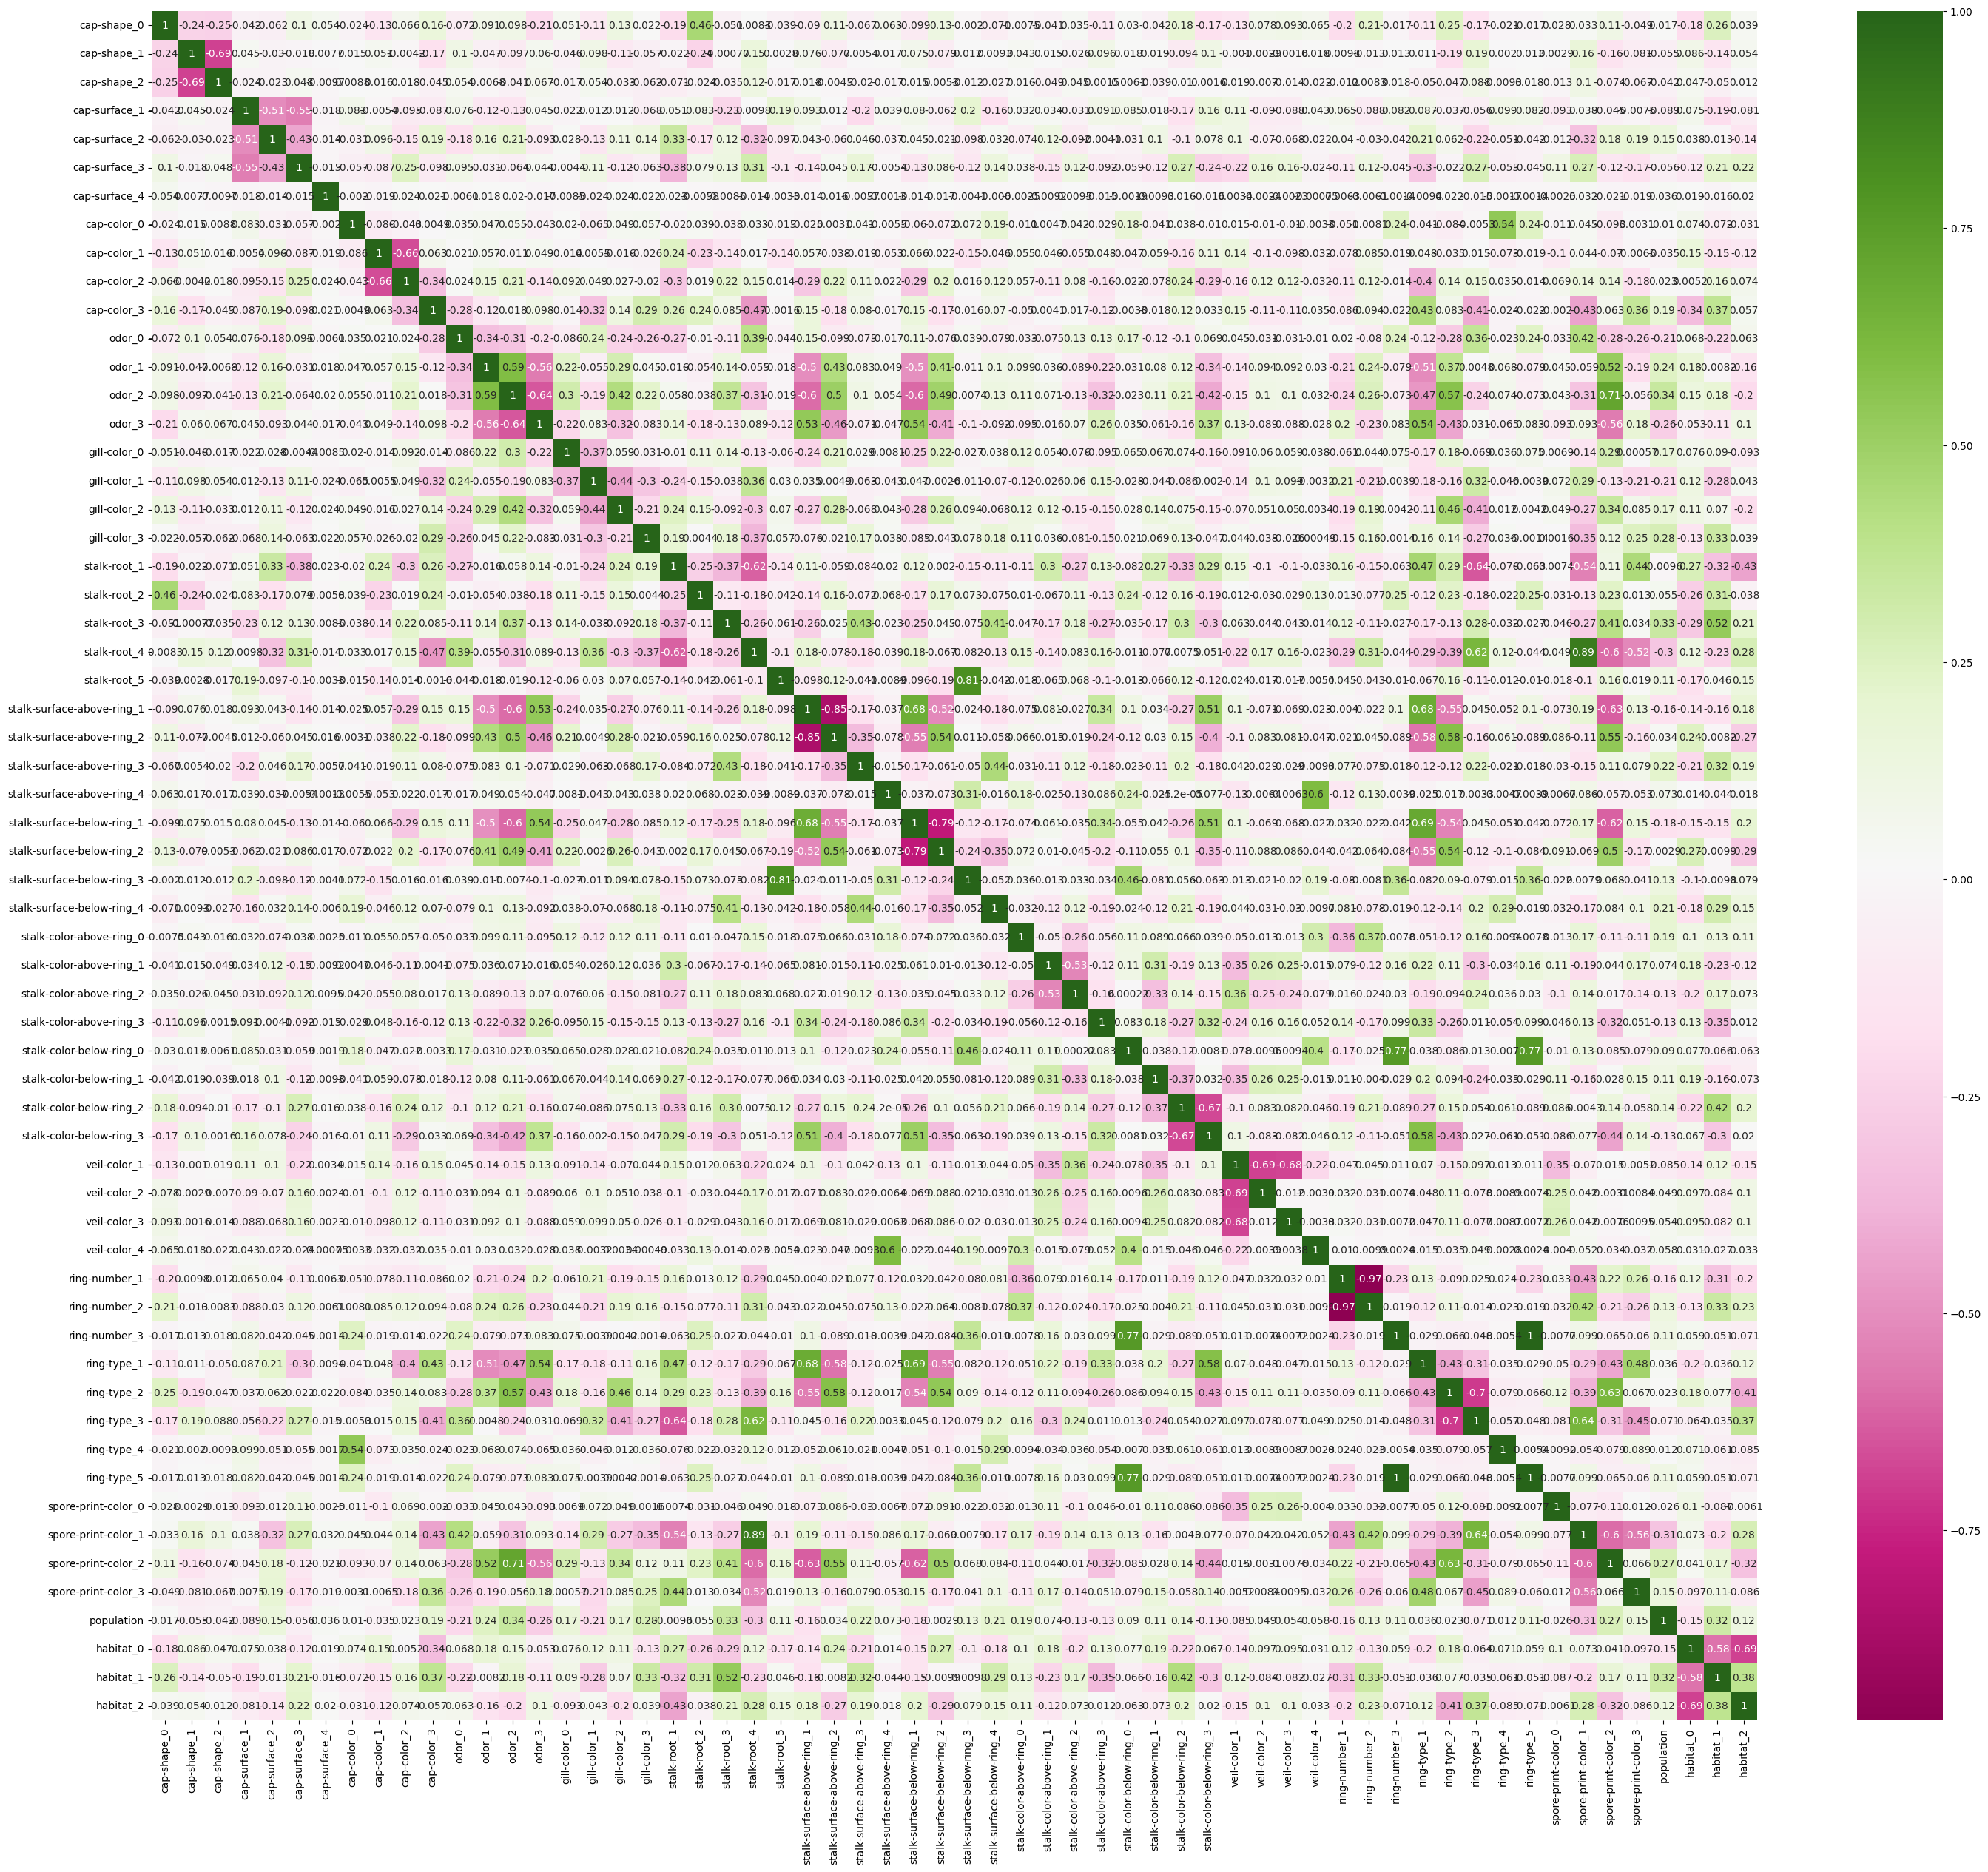

In [10]:
# correlation matrix
plt.figure(figsize=(35,30))
sns.heatmap(train_samples.corr(method="pearson"), annot=True, cmap='PiYG')
plt.show()

With how our matrix is set up, features that end up forming brightly-colored boxes and/or lines will represent those that are related: for instance, we can see that certain ring types are strongly related to certain stalk roots, which tells us that those features in combination may be significant. Other examples exist as well, like veil color and spore print color, or the stalk surface being above the ring and the ring type. Keeping this in mind, we can go through each set of related features and cross them together, providing us with aggregated features that, while not selected through expert domain knowledge, still represent a mathematically-supported linear relationship with each other.

In [11]:
cross_columns = [['veil-color_1', 'veil-color_2',
                  'veil-color_3', 'veil-color_4', 'spore-print-color_0',
                  'spore-print-color_1', 'spore-print-color_2', 'spore-print-color_3'],
                 ['stalk-surface-above-ring_1',
                  'stalk-surface-above-ring_2', 'stalk-surface-above-ring_3',
                  'stalk-surface-above-ring_4', 'ring-type_1', 'ring-type_2', 'ring-type_3',
                  'ring-type_4', 'ring-type_5'],
                 ['stalk-surface-below-ring_1',
                  'stalk-surface-below-ring_2', 'stalk-surface-below-ring_3',
                  'stalk-surface-below-ring_4', 'ring-type_1', 'ring-type_2', 'ring-type_3',
                  'ring-type_4', 'ring-type_5'],
                 ['stalk-root_1', 'stalk-root_2', 'stalk-root_3',
                  'stalk-root_4', 'stalk-root_5', 'ring-type_1', 'ring-type_2', 'ring-type_3',
                  'ring-type_4', 'ring-type_5'],
                 ['stalk-root_1', 'stalk-root_2', 'stalk-root_3',
                  'stalk-root_4', 'stalk-root_5', 'spore-print-color_0',
                  'spore-print-color_1', 'spore-print-color_2', 'spore-print-color_3']
]

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()

    # 1. create crossed labels by join operation
    X_crossed_train = train_samples[cols_list].apply(lambda x: '__'.join(str(x)), axis=1)
    X_crossed_test = test_samples[cols_list].apply(lambda x: '__'.join(str(x)), axis=1)

    # get a nice name for this new crossed column
    cross_col_name = '__'.join(cols_list)

    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))

    # 3. Save into dataframe with new name
    train_samples[cross_col_name] = enc.transform(X_crossed_train)
    test_samples[cross_col_name] = enc.transform(X_crossed_test)

    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name)

print(cross_col_df_names)

['veil-color_1__veil-color_2__veil-color_3__veil-color_4__spore-print-color_0__spore-print-color_1__spore-print-color_2__spore-print-color_3', 'stalk-surface-above-ring_1__stalk-surface-above-ring_2__stalk-surface-above-ring_3__stalk-surface-above-ring_4__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5', 'stalk-surface-below-ring_1__stalk-surface-below-ring_2__stalk-surface-below-ring_3__stalk-surface-below-ring_4__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5', 'stalk-root_1__stalk-root_2__stalk-root_3__stalk-root_4__stalk-root_5__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5', 'stalk-root_1__stalk-root_2__stalk-root_3__stalk-root_4__stalk-root_5__spore-print-color_0__spore-print-color_1__spore-print-color_2__spore-print-color_3']


Now that we have a set of crossed features, let's check to see if we have any features that do not explain the classification target, which we can therefore remove to eliminate noise during the PCA.

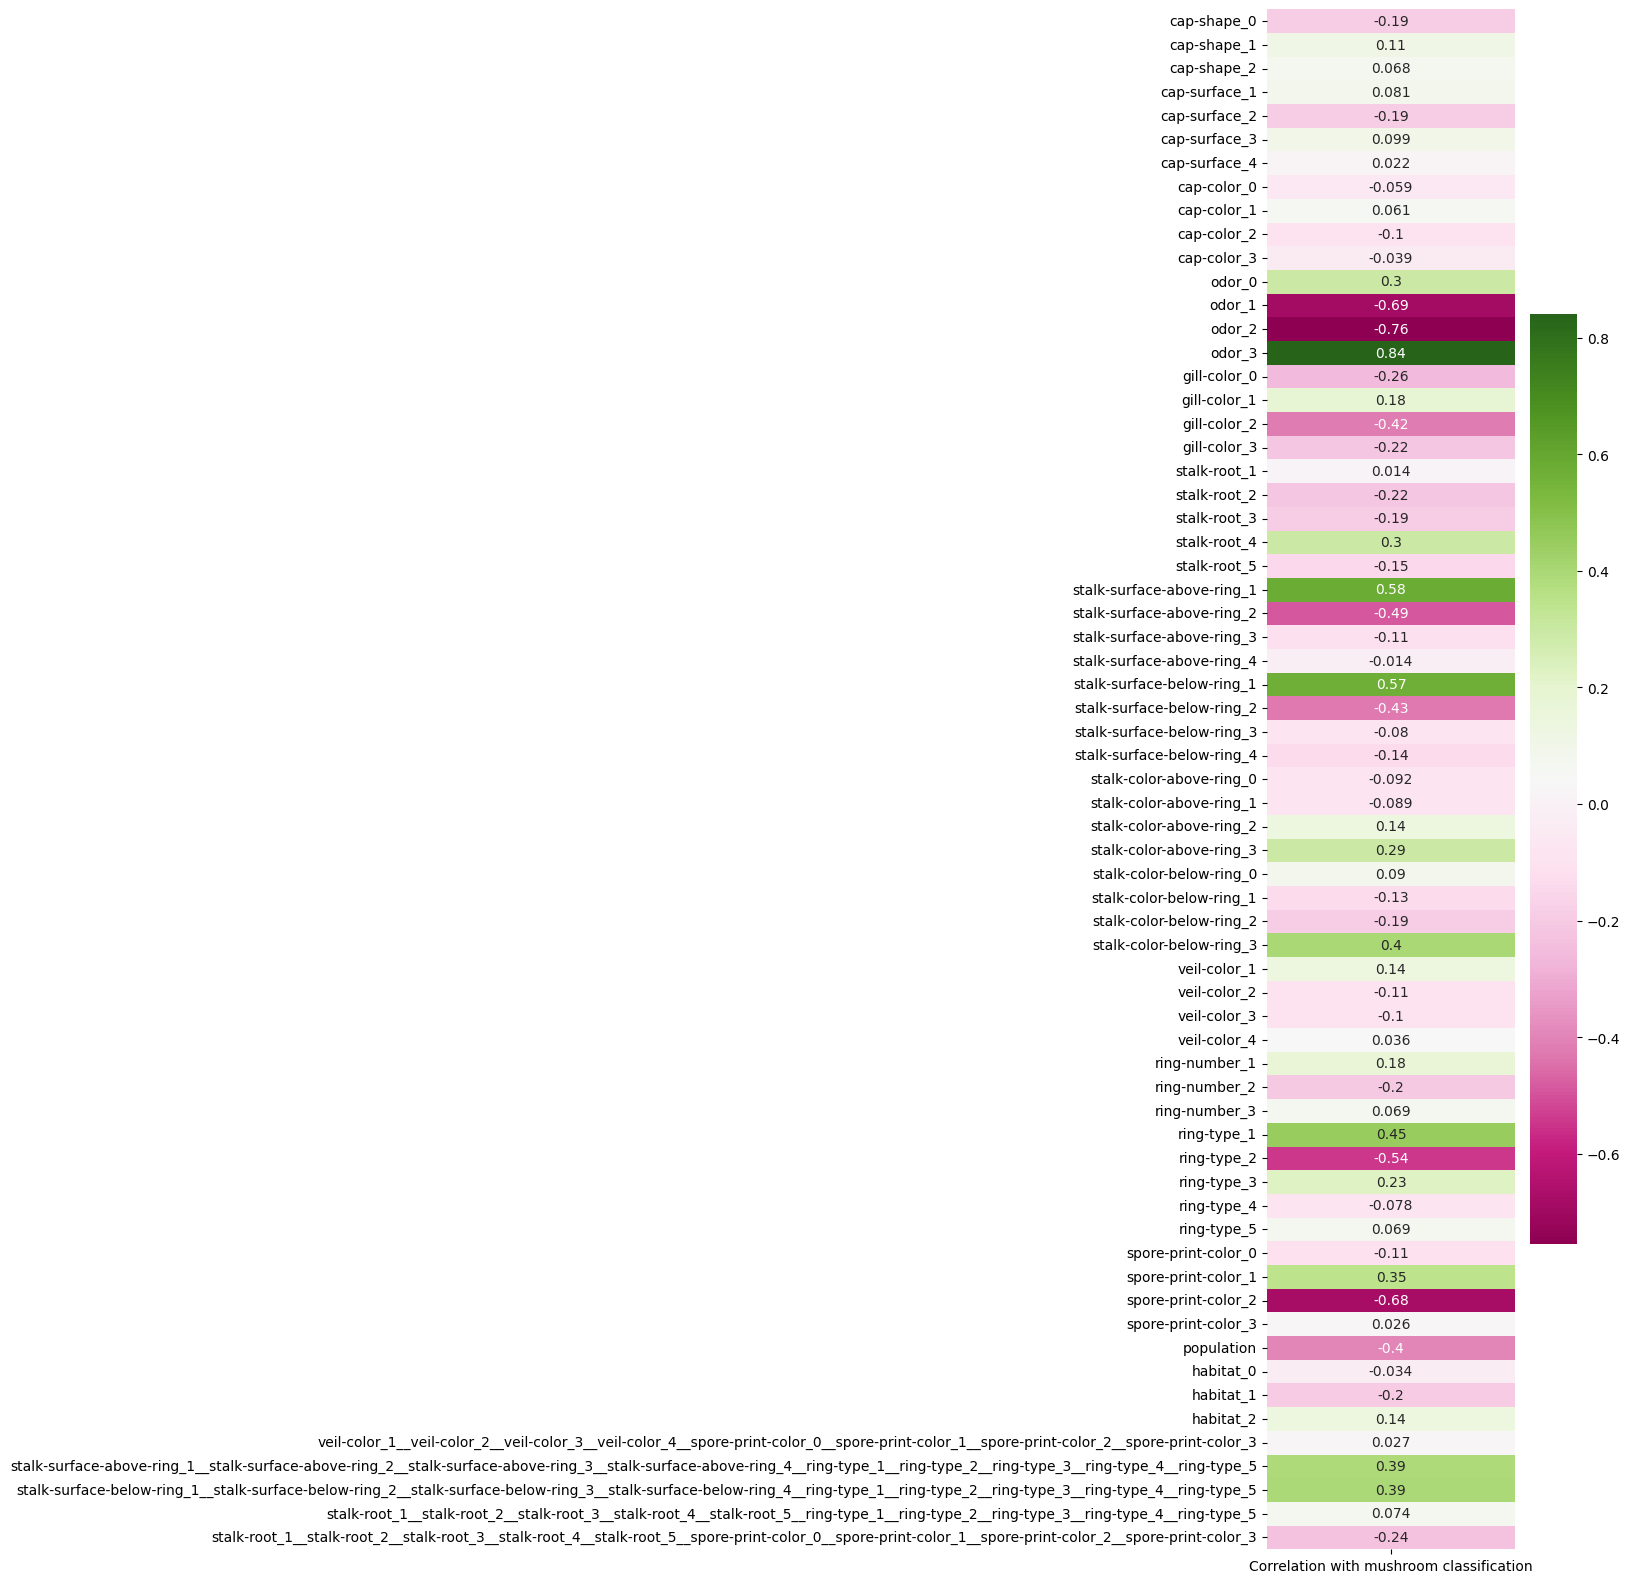

In [12]:
plt.figure(figsize=(4,20))
sns.heatmap(train_samples.corrwith(train_target, method="pearson").to_frame("Correlation with mushroom classification"), annot=True, cmap='PiYG')
plt.show()

It appears that our feature crossing was successful, with several of the new composite features providing a >|.5| correlation with our classification target! However, there are a number of features that are providing <|0.05| correlation, which can safely be removed to assist the PCA in finding relevant components.

In [13]:
train_samples.drop(columns=["cap-shape_2", "cap-surface_4", "cap-color_0", "cap-color_1", "odor_3", "gill-color_1", "stalk-surface-above-ring_4", "veil-color_4", "spore-print-color_0", "spore-print-color_3", "stalk-root_1"], axis=1, inplace=True)
test_samples.drop(columns=["cap-shape_2", "cap-surface_4", "cap-color_0", "cap-color_1", "odor_3", "gill-color_1", "stalk-surface-above-ring_4", "veil-color_4", "spore-print-color_0", "spore-print-color_3", "stalk-root_1"], axis=1, inplace=True)

Speaking of PCA, we need to ensure that we apply the appropriate form of PCA: most notably, we must understand if our data is linearly separable, or risk applying an irrelevant PCA kernel onto our data and ruining the hard work we have put into data preprocessing thus far.

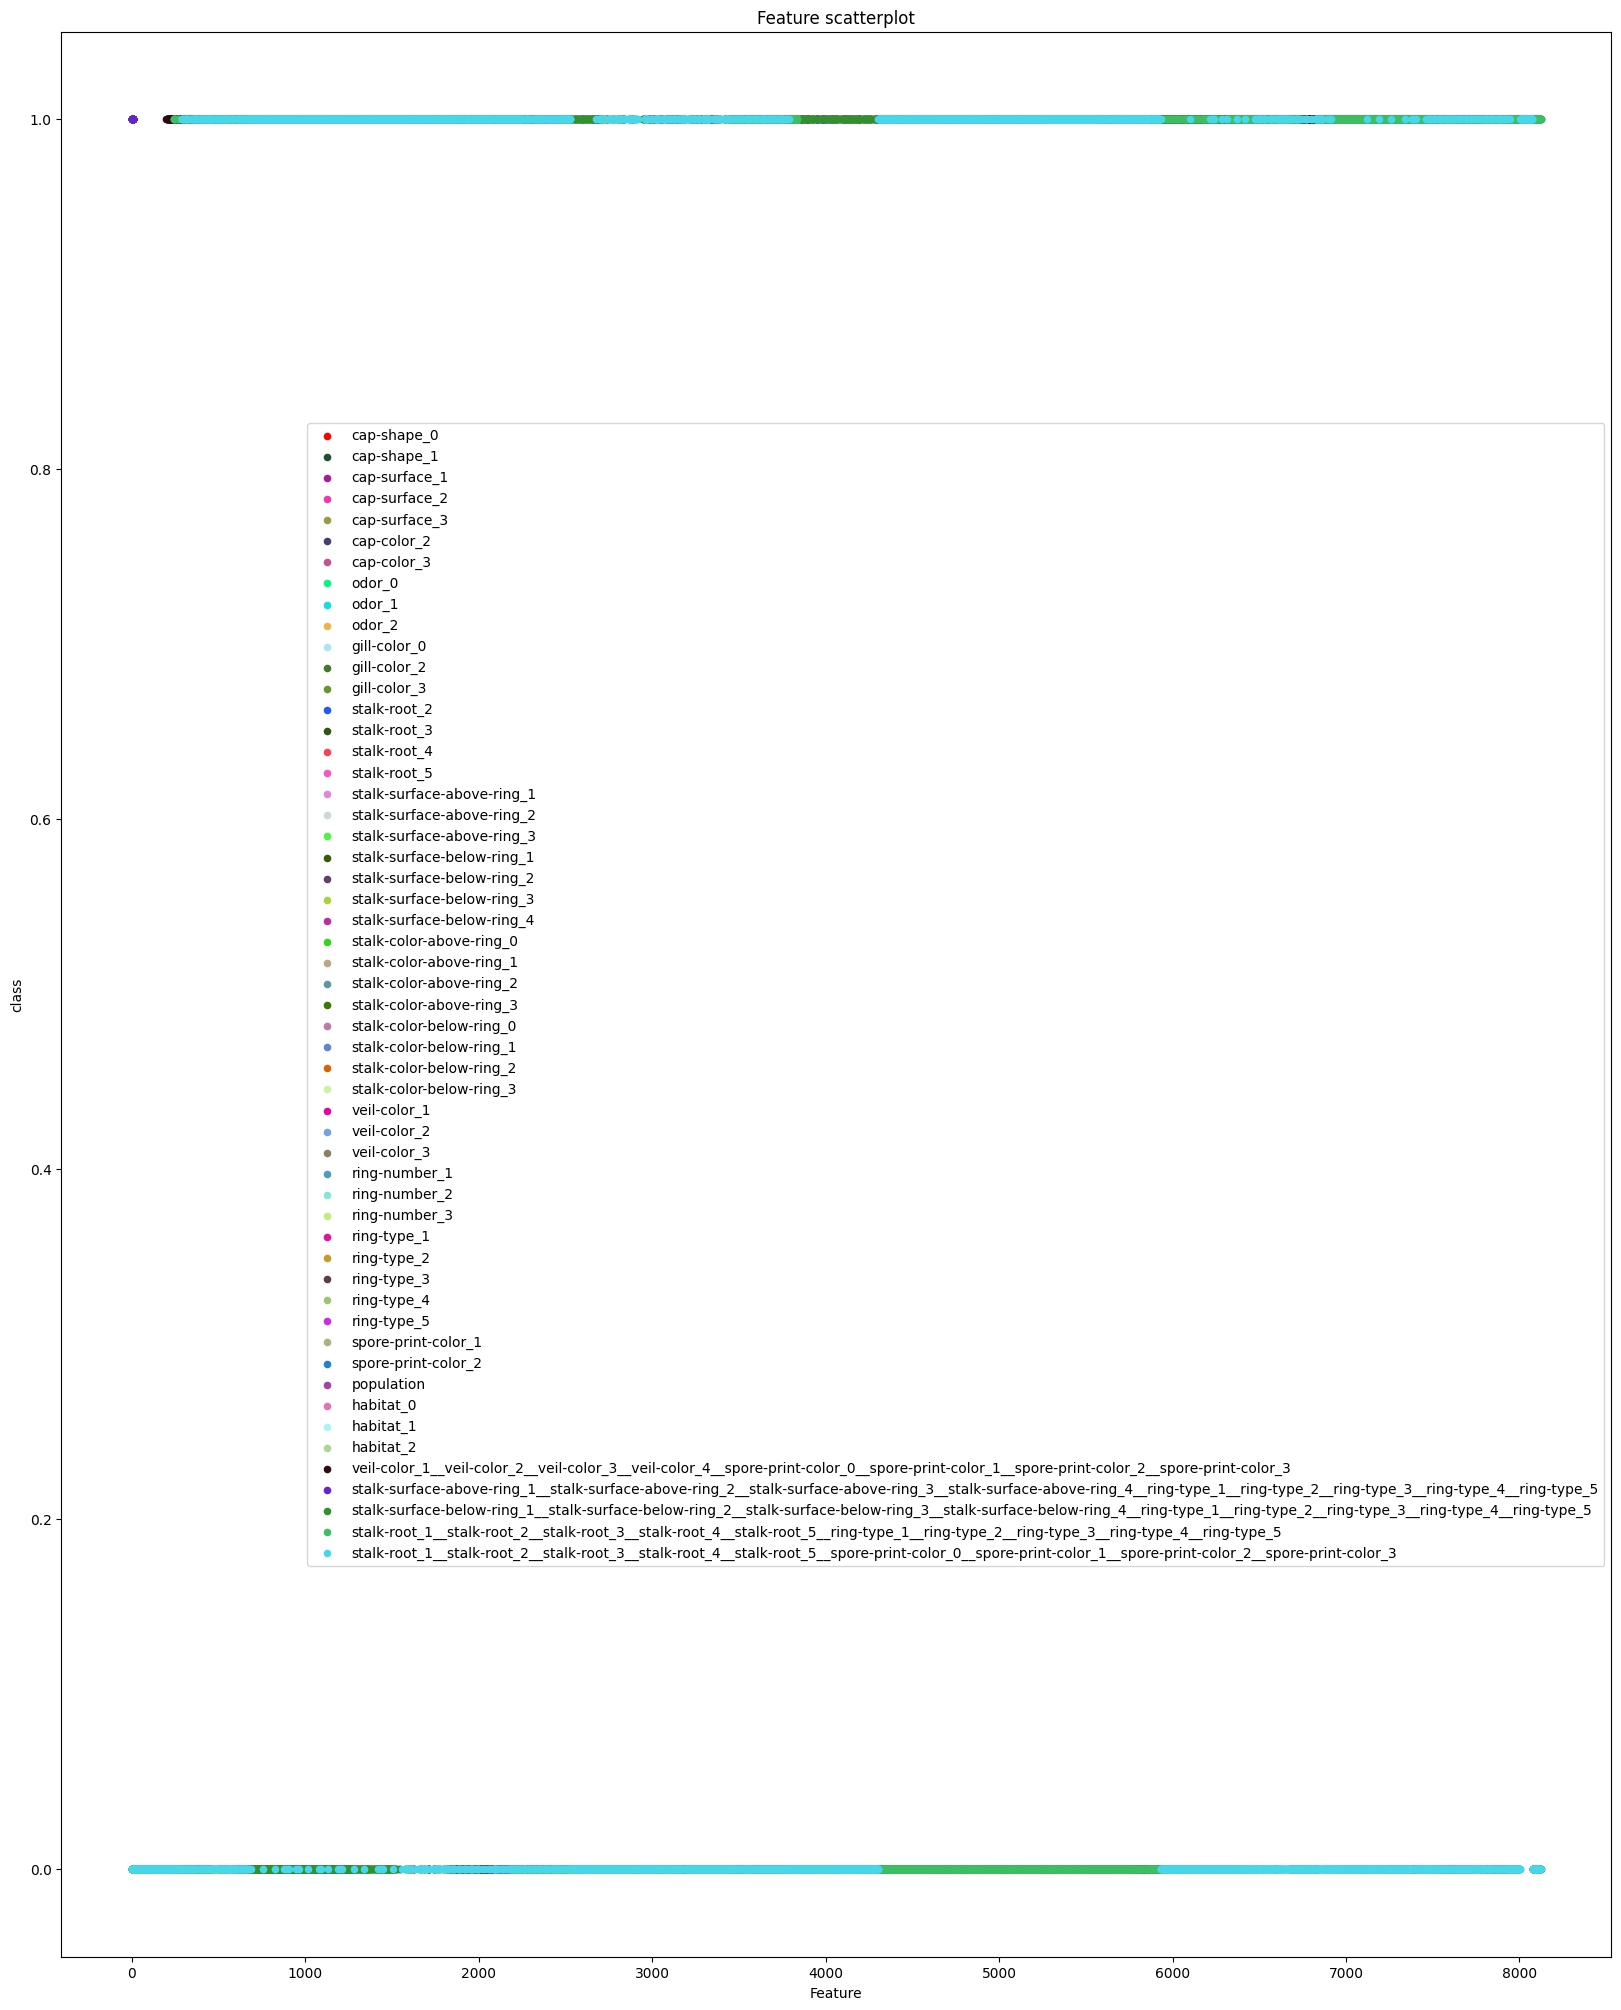

In [14]:
train_samples["class"] = train_target
axis = train_samples.plot.scatter(x="cap-shape_0", y="class", label="cap-shape_0", color="r", figsize=(20,25))

for column in train_samples.columns[1:]:
    if column == "class":
        continue
    color = (random.random(), random.random(), random.random())
    train_samples.plot.scatter(x=column, y="class", label=column, color=color, ax=axis)
axis.set_xlabel("Feature")
axis.set_title("Feature scatterplot")
plt.show()

train_samples.drop(columns=["class"], axis=1, inplace=True)

Based on the graph above, the data represents a relationship where each classification of data can be separated with a straight line, meaning a linear PCA-based decomposition should be able to accurately separate the data. With our data otherwise being preprocessed, we can now apply the PCA and evaluate whether it is able to detect meaningful components and successfully explain the variance of our dataset:

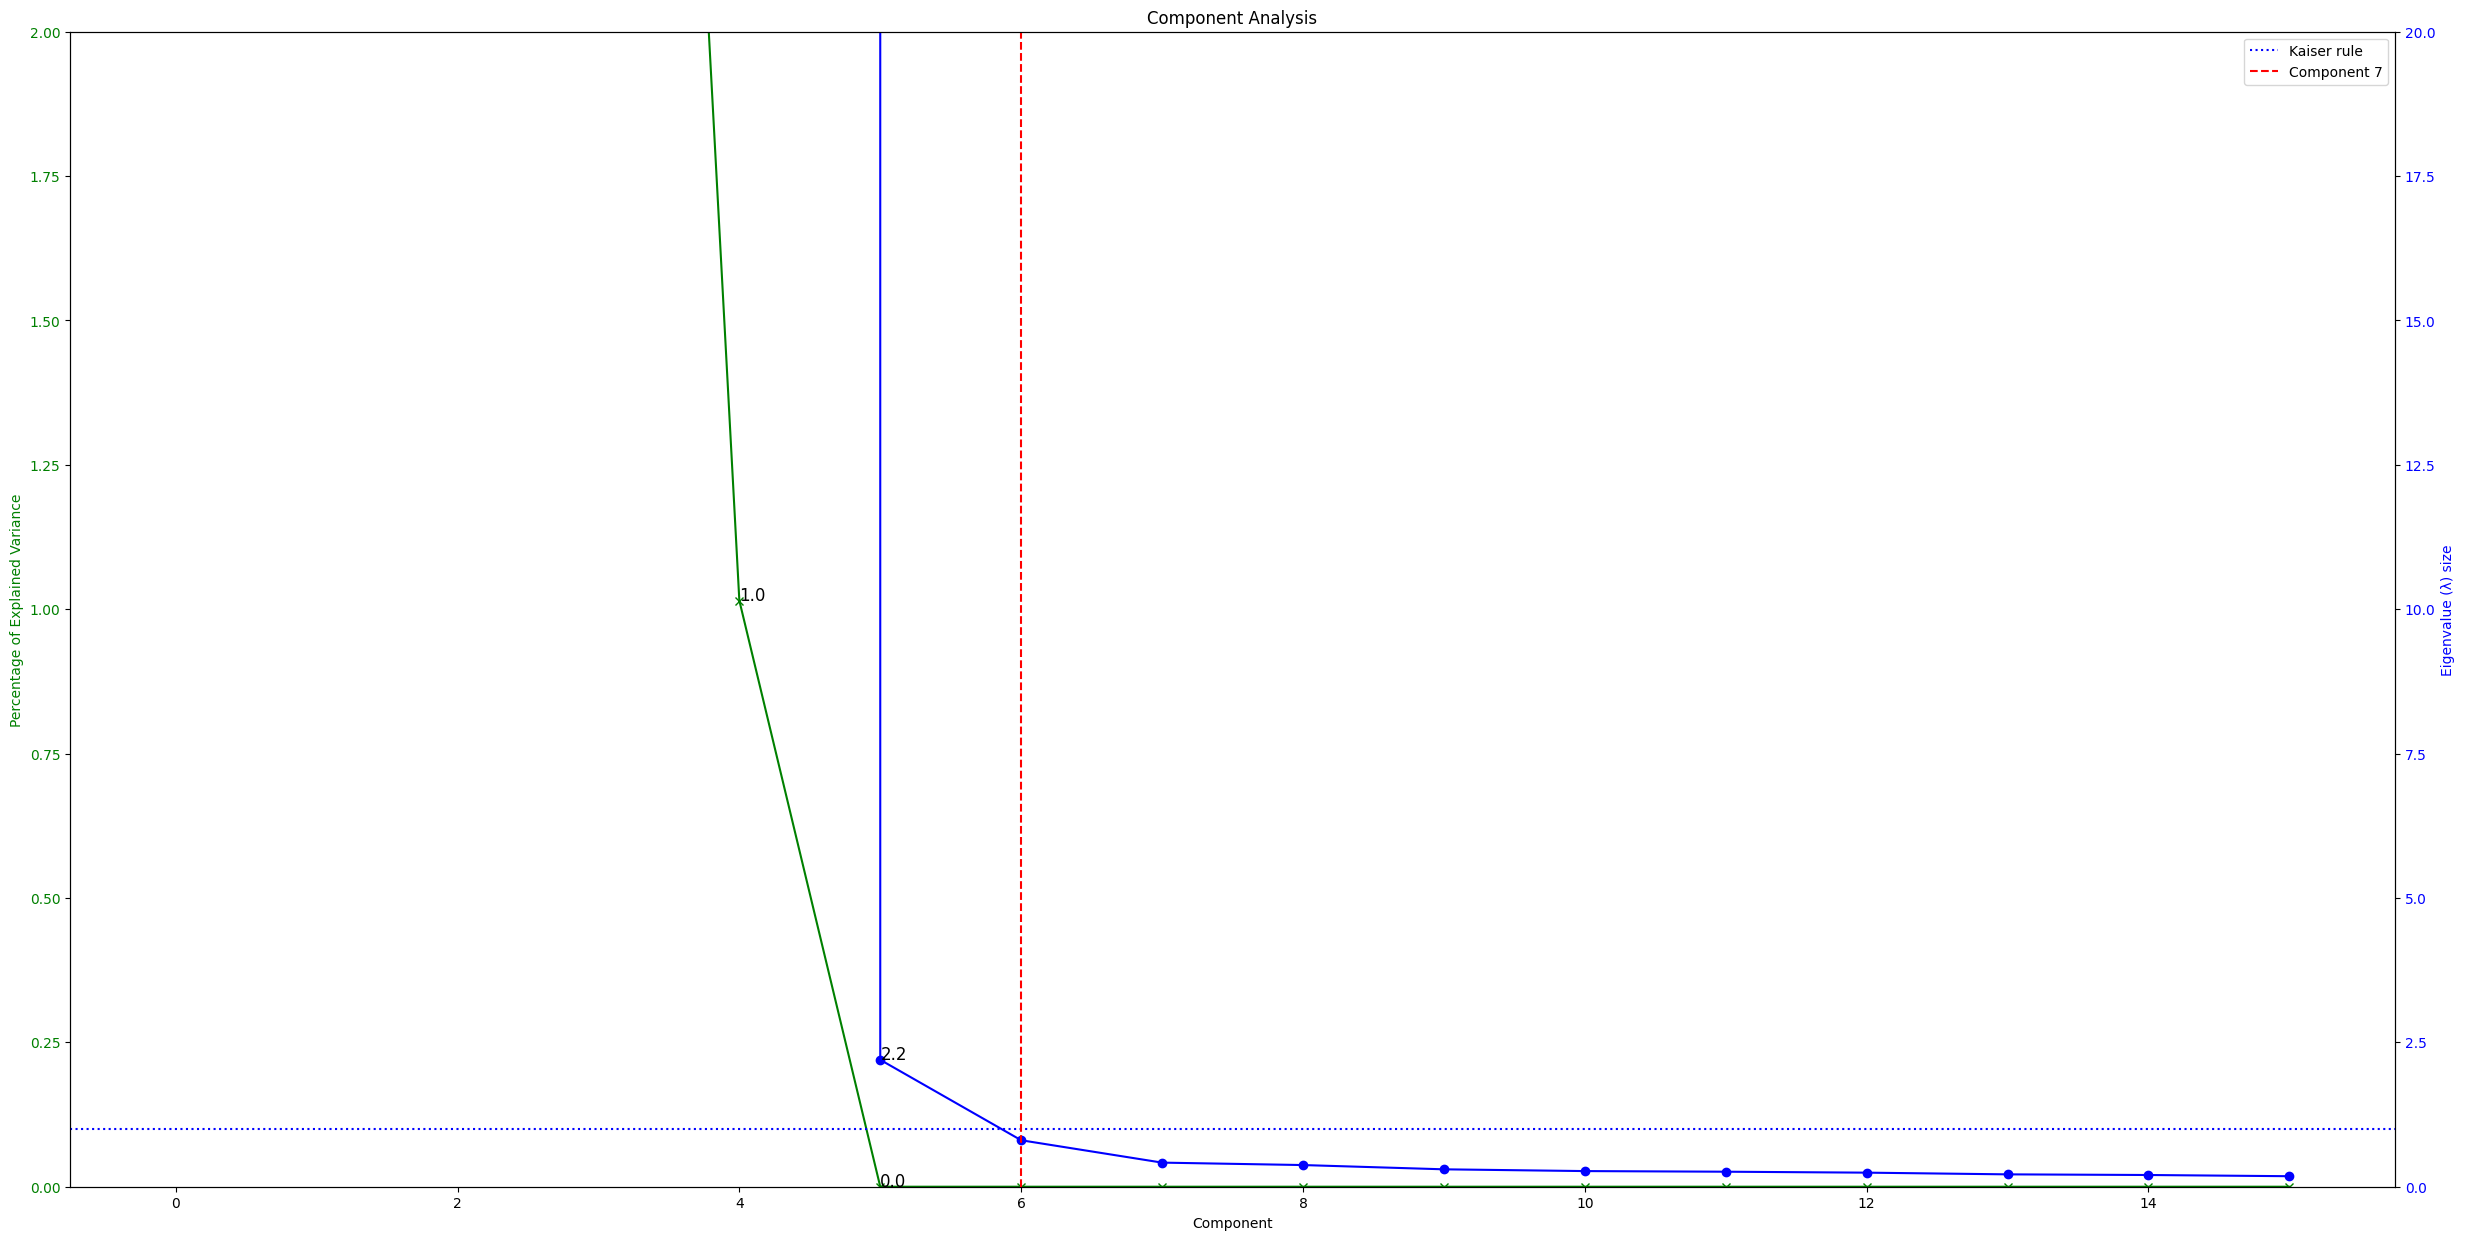

Amount of variance explained by 6 components s.t. λ_component > 1: 100%


In [15]:
# Linear PCA
pca = PCA(n_components=16, svd_solver="full")
pca_results = pca.fit_transform(train_samples)

color_var = "#008000"
color_eig = "#0000FF"
cutoff = 1
ylim = 2
fig, ax_var = plt.subplots(figsize=(30,15))
ax_eig = ax_var.twinx()
ax_var.set_xlabel("Component")
ax_var.set_title("Component Analysis")
ax_var.set_ylim(0, ylim)
ax_eig.set_ylim(0, ylim * 10)

ax_var.plot(pca.explained_variance_ratio_ * 100, marker="x", color=color_var)
ax_var.set_ylabel('Percentage of Explained Variance', color=color_var)
ax_var.tick_params(axis="y", labelcolor=color_var)

ax_eig.plot(pca.explained_variance_, marker="o", color=color_eig)
ax_eig.set_ylabel("Eigenvalue (λ) size", color=color_eig)
ax_eig.tick_params(axis="y", labelcolor=color_eig)
ax_eig.axhline(y=cutoff, linestyle=":", label="Kaiser rule", color=color_eig)

intersection = np.argwhere(np.diff(np.sign(cutoff - pca.explained_variance_))).flatten()
if len(intersection) == 0:
    num_components = len(pca.explained_variance_)
else:
    num_components = intersection[0] + 1
    ax_eig.axvline(x=num_components, linestyle="dashed", label="Component %d" %(num_components + 1), color="red")

linear_pca = PCA(n_components=num_components, svd_solver="full")
### Use these!
linear_pca_results_train = linear_pca.fit_transform(train_samples)
linear_pca_results_test = linear_pca.transform(test_samples)
### Use these!

_sum = 0
for index in range(num_components):
    if len(intersection) > 0:
        _sum = _sum + (pca.explained_variance_ratio_[index] * 100).round(1)
    if pca.explained_variance_ratio_[index] * 100 <= ylim:
        ax_var.text(index, pca.explained_variance_ratio_[index] * 100, (pca.explained_variance_ratio_[index] * 100).round(1), size=12)
    if pca.explained_variance_[index] <= ylim * 10:
        ax_eig.text(index, pca.explained_variance_[index], pca.explained_variance_[index].round(1), size=12)

ax_eig.legend(loc="upper right")
plt.show()
print("Amount of variance explained by " + str(num_components) + " components s.t. λ_component > 1: " + str(min(100, _sum)) + "%")

With all of our variance being able to be almost entirely explained in just a half-dozen components (as compared to our original 66 dimensions!), we can now move on to describing the final dataset which we shall be using, and then determine a metric we want to use to measure the overall performance of our models.

In [16]:
print(train_samples.columns)
train_samples.head()

Index(['cap-shape_0', 'cap-shape_1', 'cap-surface_1', 'cap-surface_2',
       'cap-surface_3', 'cap-color_2', 'cap-color_3', 'odor_0', 'odor_1',
       'odor_2', 'gill-color_0', 'gill-color_2', 'gill-color_3',
       'stalk-root_2', 'stalk-root_3', 'stalk-root_4', 'stalk-root_5',
       'stalk-surface-above-ring_1', 'stalk-surface-above-ring_2',
       'stalk-surface-above-ring_3', 'stalk-surface-below-ring_1',
       'stalk-surface-below-ring_2', 'stalk-surface-below-ring_3',
       'stalk-surface-below-ring_4', 'stalk-color-above-ring_0',
       'stalk-color-above-ring_1', 'stalk-color-above-ring_2',
       'stalk-color-above-ring_3', 'stalk-color-below-ring_0',
       'stalk-color-below-ring_1', 'stalk-color-below-ring_2',
       'stalk-color-below-ring_3', 'veil-color_1', 'veil-color_2',
       'veil-color_3', 'ring-number_1', 'ring-number_2', 'ring-number_3',
       'ring-type_1', 'ring-type_2', 'ring-type_3', 'ring-type_4',
       'ring-type_5', 'spore-print-color_1', 'spore-prin

cap-shape_0  cap-shape_1  cap-surface_1  cap-surface_2  cap-surface_3  \
4773            0            0              1              0              0   
559             0            0              1              0              0   
4344            0            1              0              1              0   
785             0            0              0              0              1   
6471            0            1              0              0              1   

      cap-color_2  cap-color_3  odor_0  odor_1  odor_2  ...  \
4773            0            1       0       0       0  ...   
559             0            1       0       0       1  ...   
4344            0            1       0       0       0  ...   
785             1            0       0       0       1  ...   
6471            1            0       0       0       0  ...   

      spore-print-color_2  population  habitat_0  habitat_1  habitat_2  \
4773                    0           1          0          0          1   
559                     1           2          0          1          0   
4344                    0           1          0          1          1   
785                     1           1          0          1          1   
6471                    0           1          1          0          0   

      veil-color_1__veil-color_2__veil-color_3__veil-color_4__spore-print-color_0__spore-print-color_1__spore-print-color_2__spore-print-color_3  \
4773                                               1112                                                                                            
559                                                3517                                                                                            
4344                                                728                                                                                            
785                                                5508                                                                                            
6471                                               6546                                                                                            

      stalk-surface-above-ring_1__stalk-surface-above-ring_2__stalk-surface-above-ring_3__stalk-surface-above-ring_4__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5  \
4773                                               7706                                                                                                                                 
559                                                4885                                                                                                                                 
4344                                               7342                                                                                                                                 
785                                                5462                                                                                                                                 
6471                                               6139                                                                                                                                 

      stalk-surface-below-ring_1__stalk-surface-below-ring_2__stalk-surface-below-ring_3__stalk-surface-below-ring_4__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5  \
4773                                               7706                                                                                                                                 
559                                                5040                                                                                                                                 
4344                                               7342                                                                                                 

Concerning the dataset: the vast majority of the features, totalling 66, are simply existing features that have been split out via an appropriate encoding algorithm. For instance, cap shape, cap surface, and cap color already existed in the original dataset and have been split out into sets of either dummy or one-hot encoded features, depending on applicability. There are, however, several exceptions: the crossed features (noted by their long-winded column names) represent amalgamated features that showed a strong linear relationship with each other when viewed under a Pearson correlation study. While the team writing this paper does not have the relevant domain knowledge to ascribe formalized meaning to these relationships, we can confidently state that they represent a more complex relationship that evidences a property of mushrooms in general, much like how crossing most bird's coloration & size would end up being representative of their sex.

But even with the dataset built, we must have a metric which we weigh the performance of a model on it with. Accuracy is a common, if often inappropriate measurement, and we believe we can improve upon using solely this metric. In our case, our dataset is exactly balanced, meaning that accuracy could be a useful metric for determining how often we predict the correct answer, however when considering the meaning of the dataset and what we are trying to classify (whether a mushroom is poisonous or edible), additional metrics can come in handy.
For example, a false negative for a mushroom being poisonous could have disastrous consequences for the person relying on the classification: with this in mind, recall/sensitivity would be an appropriate metric, as we want to minimize the false negative rate as much as possible. However, we still want to make sure that we are preforming well with respect to the true positive class, as a false positive could still have significant consequences in the case of a false edibility classification. For this reason, we can also utilize the precision metric, and take an aggregate performance measure of both of these (with our recall/sensitivity being somewhat more important that our precision) through an F1 score.
With all of these 4 metric combined, we should have a very strong foundation for determining the general performance and suitability of our models on our dataset.

## Modeling

Now we will begin modelling. As mentioned above, the metrics we will use to measure performance will be using the precision metric and recall/sensitivity aggregate through an F1 score. 

Let's start by building a normal Multilayer Perceptron to compare our other multimodal architectures against.
The architecture will consist of 3 fully connected layers:

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,049
Trainable params: 34,049
Non-trainable params: 0
_________________________________________________________________


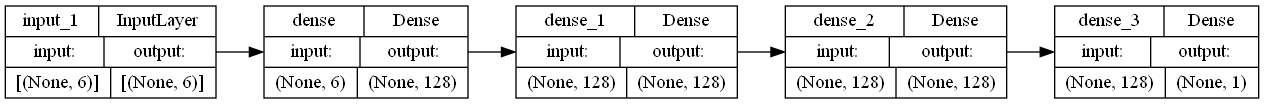

In [17]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from keras.optimizers import SGD, Adagrad

accuracies = []

def create_model(optimizer='adam', activation='relu', hidden_layers=3, neurons=128):
    num_features = linear_pca_results_train.shape[1]
    input_tensor = Input(shape=(num_features,))
    
    x = Dense(units=neurons, activation=activation)(input_tensor)
    for _ in range(hidden_layers - 1):
        x = Dense(units=neurons, activation=activation)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_tensor, outputs=predictions)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

deep_model = create_model()
deep_model.summary()

plot_model(
    deep_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [18]:
import matplotlib.pyplot as plt

def plot_model_history(history):    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


21/21 [==============================] - 0s 775us/step
[[334   2]
 [ 38 276]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       336
           1       0.99      0.88      0.93       314

    accuracy                           0.94       650
   macro avg       0.95      0.94      0.94       650
weighted avg       0.94      0.94      0.94       650



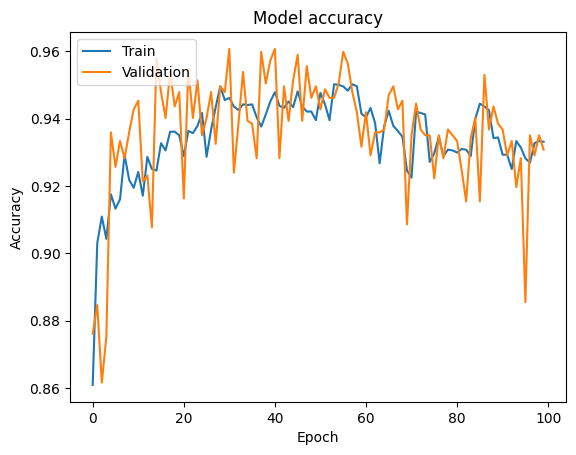

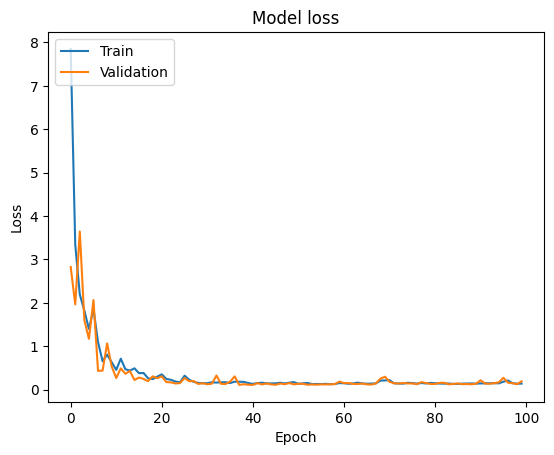

21/21 [==============================] - 0s 876us/step
[[331   5]
 [ 32 282]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       336
           1       0.98      0.90      0.94       314

    accuracy                           0.94       650
   macro avg       0.95      0.94      0.94       650
weighted avg       0.95      0.94      0.94       650



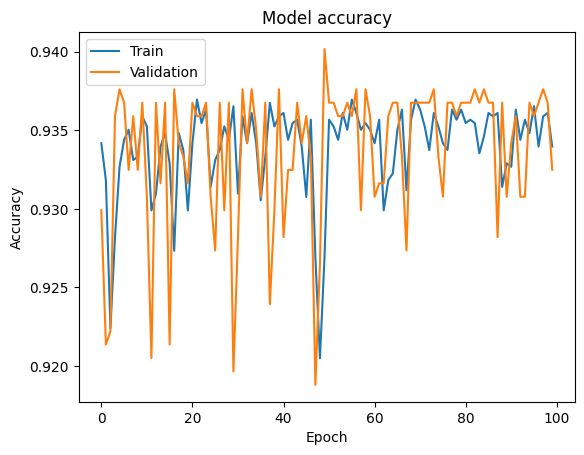

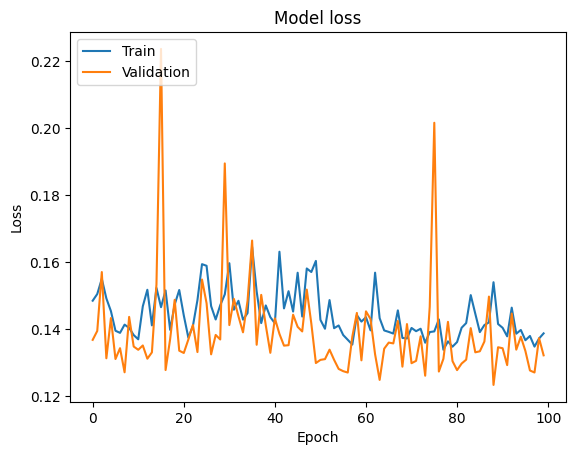

21/21 [==============================] - 0s 750us/step
[[335   1]
 [ 42 272]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       336
           1       1.00      0.87      0.93       314

    accuracy                           0.93       650
   macro avg       0.94      0.93      0.93       650
weighted avg       0.94      0.93      0.93       650



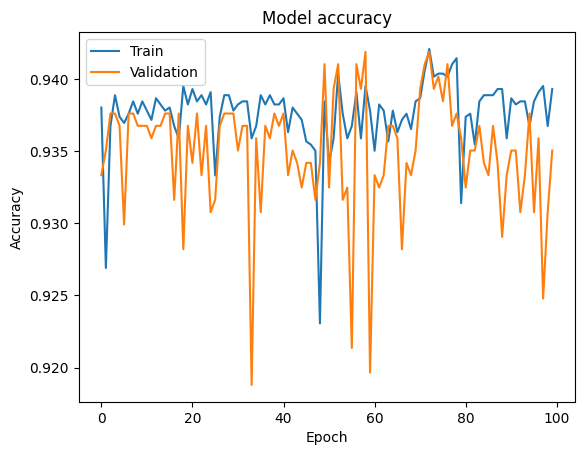

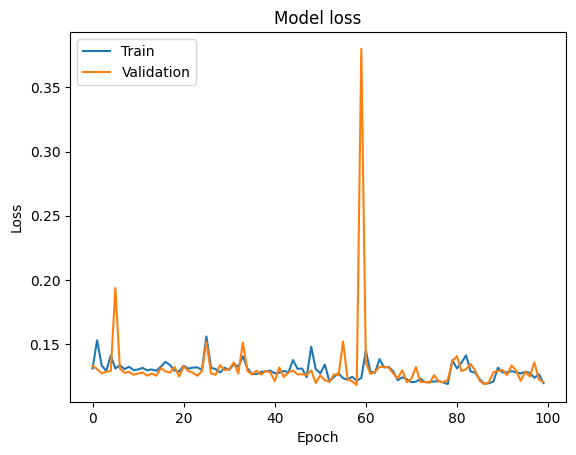

21/21 [==============================] - 0s 875us/step
[[336   1]
 [ 39 274]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       337
           1       1.00      0.88      0.93       313

    accuracy                           0.94       650
   macro avg       0.95      0.94      0.94       650
weighted avg       0.94      0.94      0.94       650



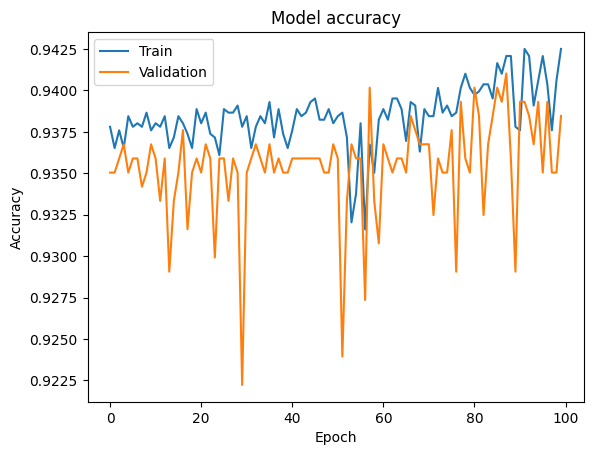

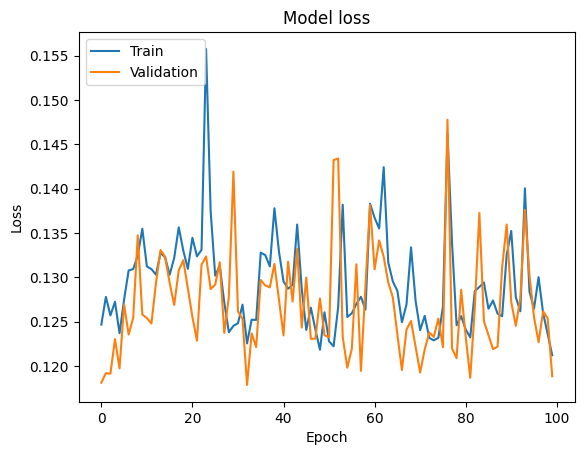

21/21 [==============================] - 0s 750us/step
[[335   2]
 [ 39 274]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       337
           1       0.99      0.88      0.93       313

    accuracy                           0.94       650
   macro avg       0.94      0.93      0.94       650
weighted avg       0.94      0.94      0.94       650



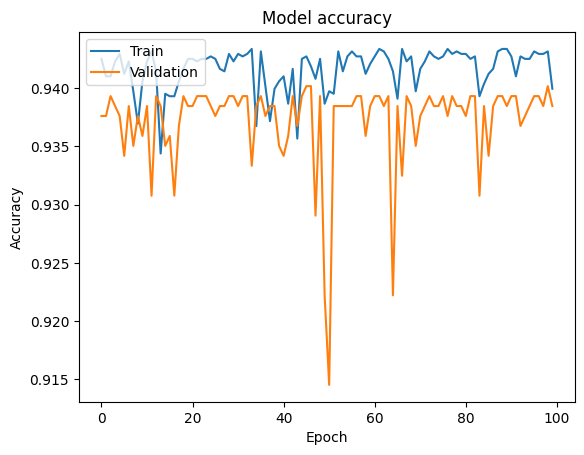

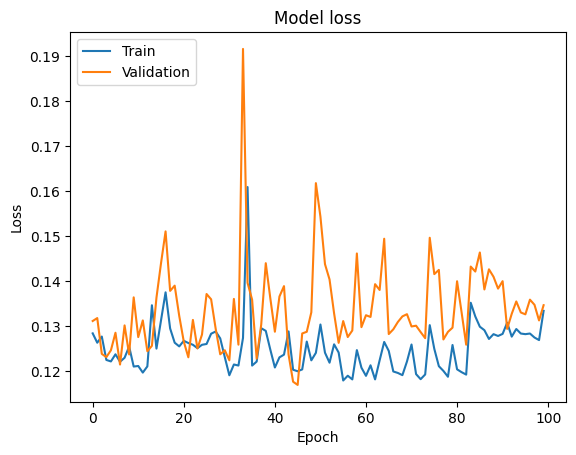

21/21 [==============================] - 0s 725us/step
[[337   0]
 [ 34 279]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       337
           1       1.00      0.89      0.94       313

    accuracy                           0.95       650
   macro avg       0.95      0.95      0.95       650
weighted avg       0.95      0.95      0.95       650



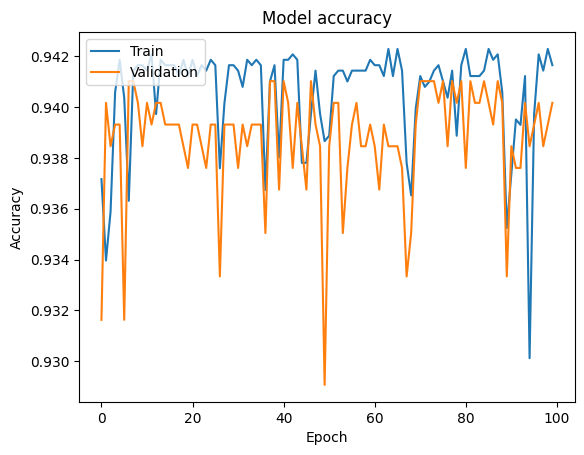

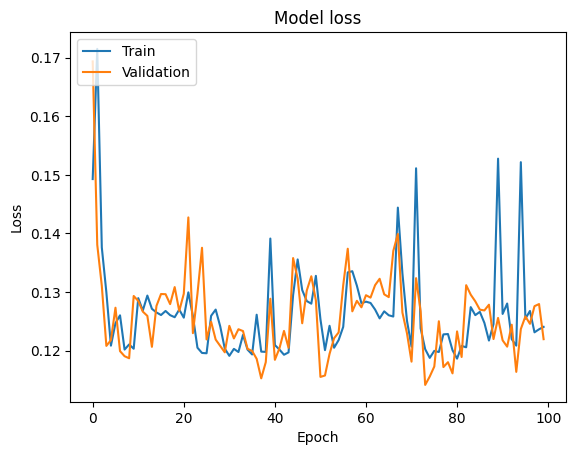

21/21 [==============================] - 0s 725us/step
[[337   0]
 [ 38 275]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       337
           1       1.00      0.88      0.94       313

    accuracy                           0.94       650
   macro avg       0.95      0.94      0.94       650
weighted avg       0.95      0.94      0.94       650



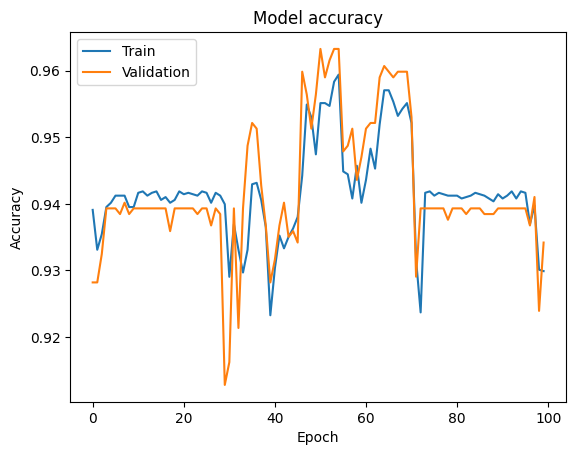

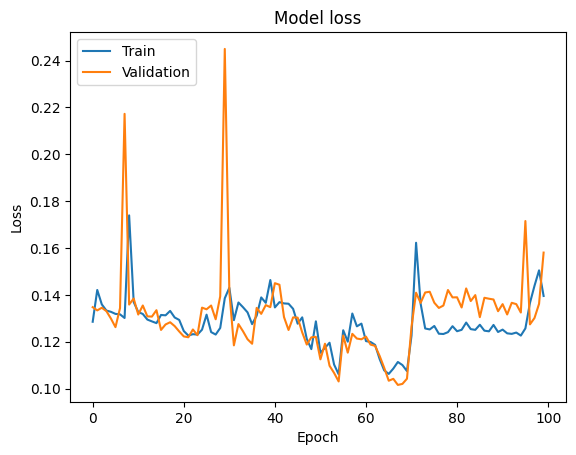

21/21 [==============================] - 0s 725us/step
[[336   1]
 [ 35 278]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       337
           1       1.00      0.89      0.94       313

    accuracy                           0.94       650
   macro avg       0.95      0.94      0.94       650
weighted avg       0.95      0.94      0.94       650



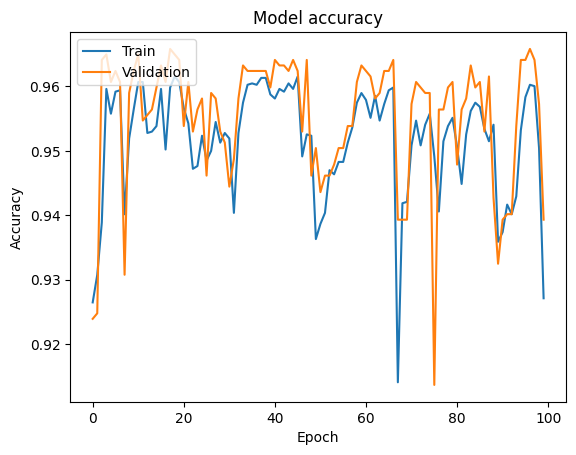

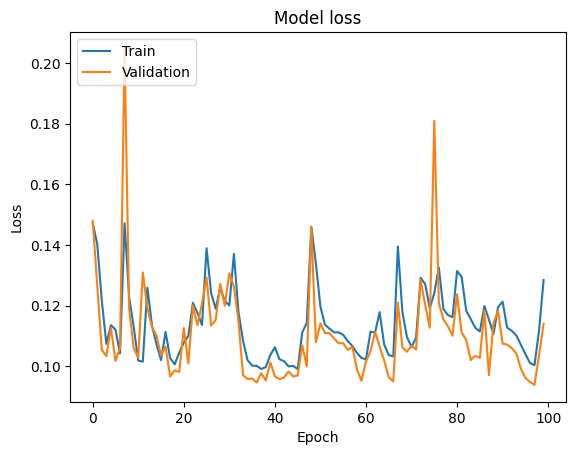

21/21 [==============================] - 0s 800us/step
[[332   5]
 [ 24 289]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       337
           1       0.98      0.92      0.95       313

    accuracy                           0.96       650
   macro avg       0.96      0.95      0.96       650
weighted avg       0.96      0.96      0.96       650



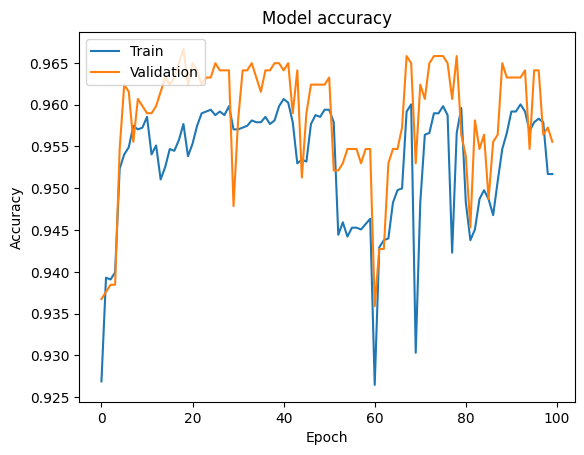

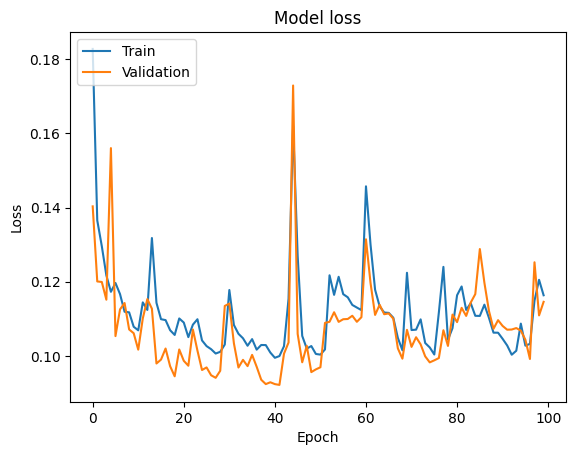

21/21 [==============================] - 0s 850us/step
[[335   1]
 [ 35 278]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       336
           1       1.00      0.89      0.94       313

    accuracy                           0.94       649
   macro avg       0.95      0.94      0.94       649
weighted avg       0.95      0.94      0.94       649



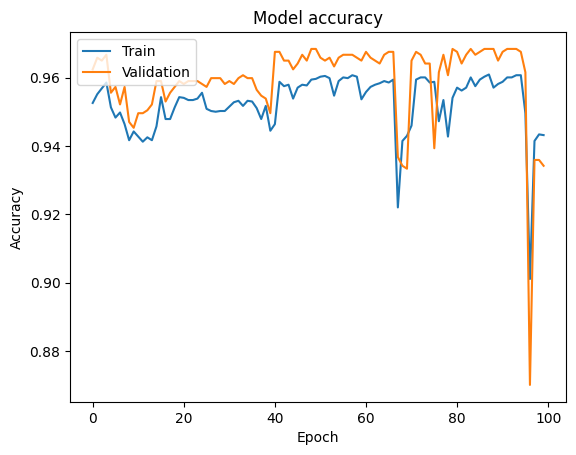

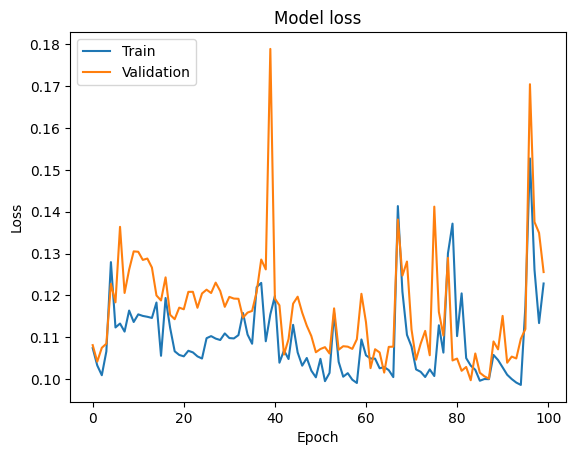

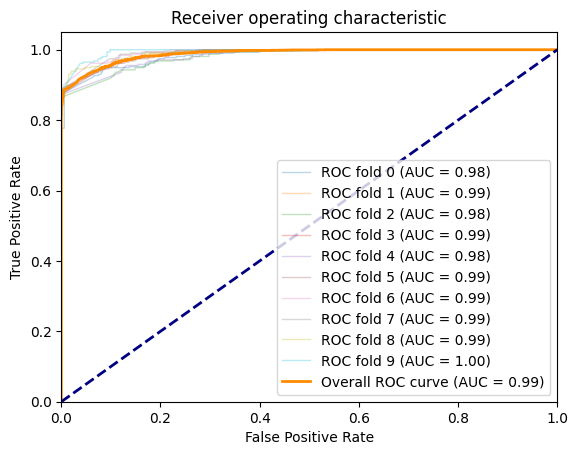

In [19]:
from sklearn.metrics import roc_curve, auc

idx = 0
history = None

# Initialize lists to store the true and predicted labels and the ROC curve data
y_true_list = []
y_proba_list = []
fpr_list = []
tpr_list = []
auc_list = []

for train, test in data_splits.split(train_samples, train_target):
    X_training_fold = linear_pca_results_train[train]
    y_training_fold = train_target.iloc[train]
    
    X_test = linear_pca_results_train[test]
    y_test = train_target.iloc[test]
    
    history = deep_model.fit(X_training_fold, y_training_fold, epochs=100, batch_size=50, verbose=0, validation_split=0.2)

    yhat_proba = deep_model.predict(X_test) # sigmoid output probabilities
    yhat = np.round(yhat_proba) # round to get binary class

    # Compute the ROC curve and AUC for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, yhat_proba)
    roc_auc = auc(fpr, tpr)
    
    # Append the true labels, predicted probabilities, and ROC curve data to the lists
    y_true_list.append(y_test)
    y_proba_list.append(yhat_proba)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

    print(mt.confusion_matrix(y_test,yhat))
    print(mt.classification_report(y_test,yhat))
    accuracies.append({"Confusion Matrix": mt.confusion_matrix(y_test,yhat), "Classification Report": mt.classification_report(y_test,yhat)})
    idx += 1
    plot_model_history(history)

# Compute the overall ROC curve and AUC for all the folds
y_true = np.concatenate(y_true_list)
y_proba = np.concatenate(y_proba_list)
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve for each fold and the overall ROC curve
plt.figure()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, auc_list[i]))
plt.plot(fpr, tpr, lw=2, color='darkorange', label='Overall ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

From the above results, we can see that the MultiLayer perceptron without any embeddings performs relatively poorly.

Now let's alter the architecture to create wide branches with proper embedding layers to represent our categorical data more effectively.

We'll start off with creating a Wide Neural Net with a single fully connected layer before the wide layer for comparison purposes


[ 648  649  651 ... 6496 6497 6498]
21/21 [==============================] - 0s 625us/step
[[234 102]
 [  4 310]]
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       336
           1       0.75      0.99      0.85       314

    accuracy                           0.84       650
   macro avg       0.87      0.84      0.83       650
weighted avg       0.87      0.84      0.83       650



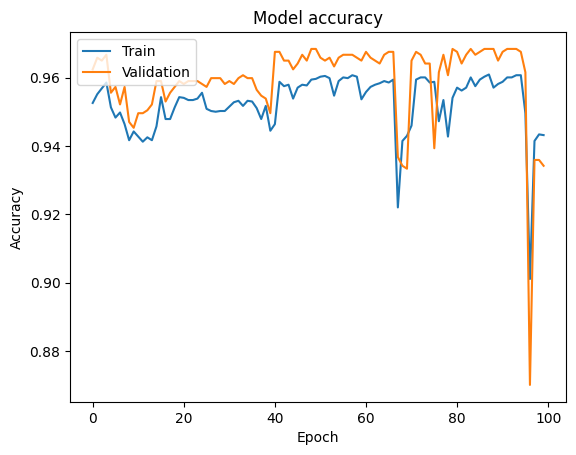

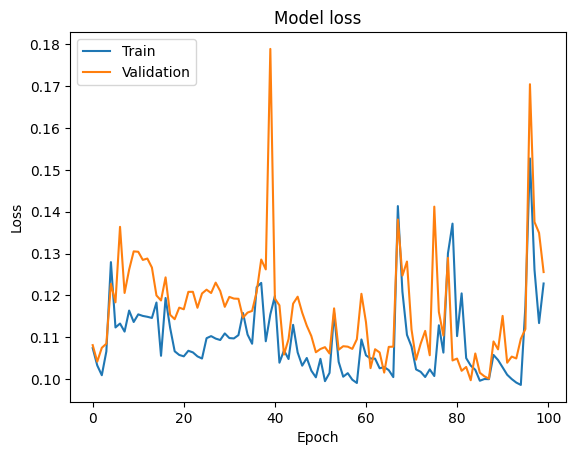

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 650us/step
[[276  60]
 [ 16 298]]
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       336
           1       0.83      0.95      0.89       314

    accuracy                           0.88       650
   macro avg       0.89      0.89      0.88       650
weighted avg       0.89      0.88      0.88       650



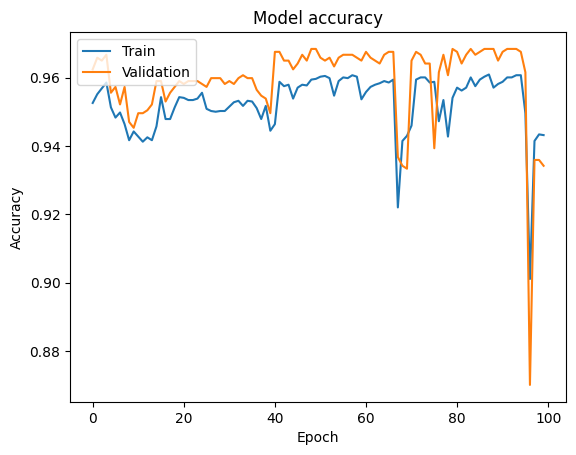

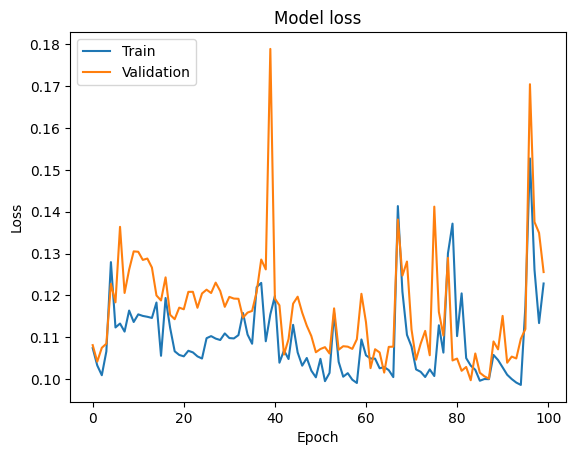

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 700us/step
[[322  14]
 [ 25 289]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       336
           1       0.95      0.92      0.94       314

    accuracy                           0.94       650
   macro avg       0.94      0.94      0.94       650
weighted avg       0.94      0.94      0.94       650



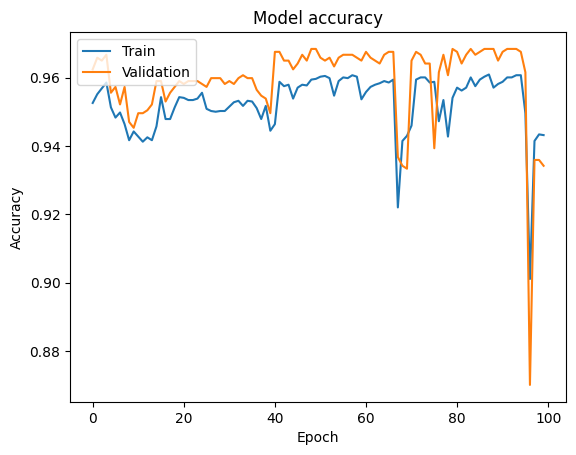

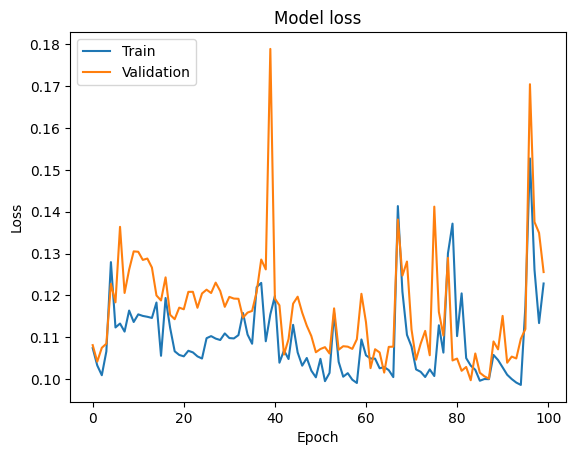

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 750us/step
[[321  16]
 [ 21 292]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       337
           1       0.95      0.93      0.94       313

    accuracy                           0.94       650
   macro avg       0.94      0.94      0.94       650
weighted avg       0.94      0.94      0.94       650



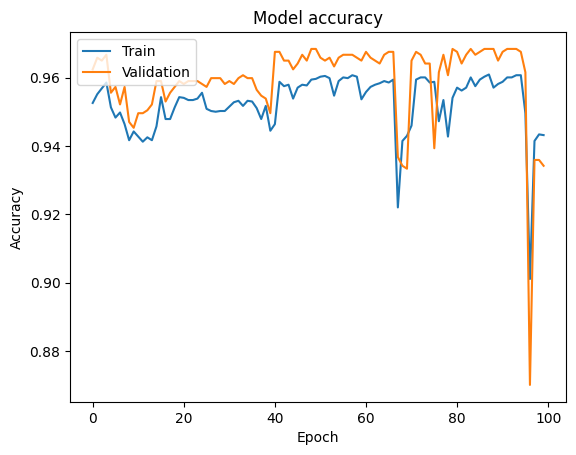

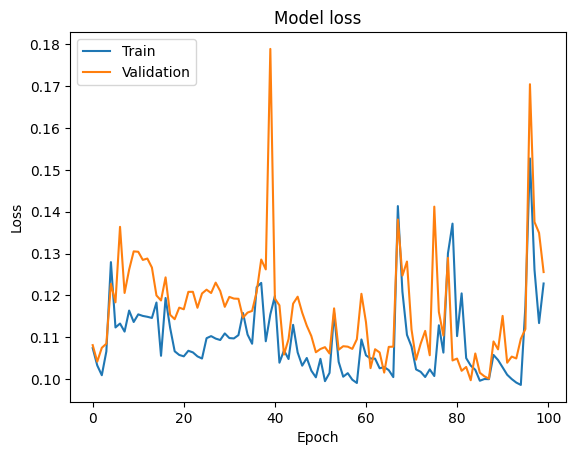

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 700us/step
[[329   8]
 [ 22 291]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       337
           1       0.97      0.93      0.95       313

    accuracy                           0.95       650
   macro avg       0.96      0.95      0.95       650
weighted avg       0.95      0.95      0.95       650



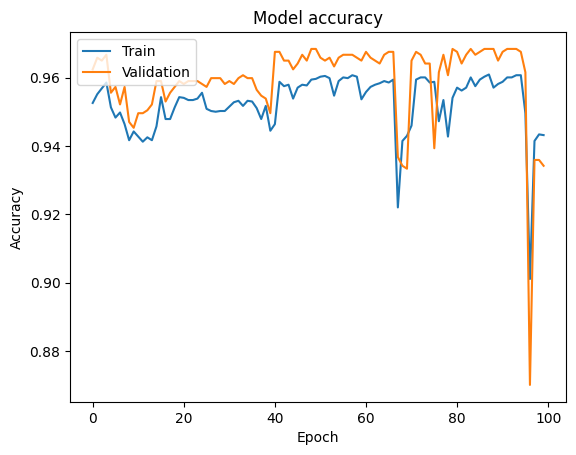

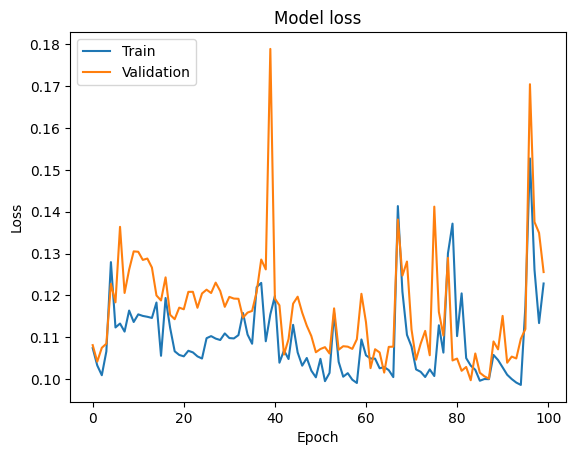

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 675us/step
[[326  11]
 [ 18 295]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       337
           1       0.96      0.94      0.95       313

    accuracy                           0.96       650
   macro avg       0.96      0.95      0.96       650
weighted avg       0.96      0.96      0.96       650



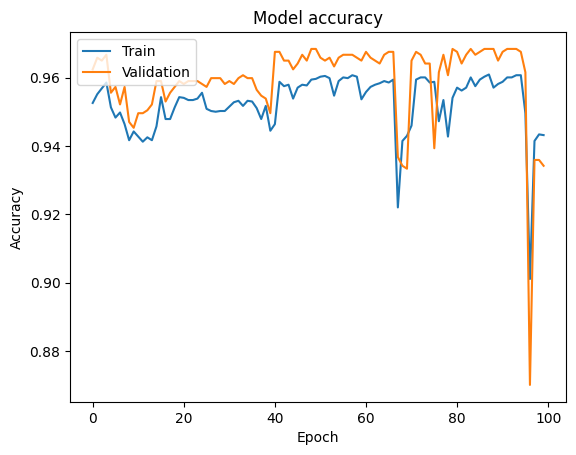

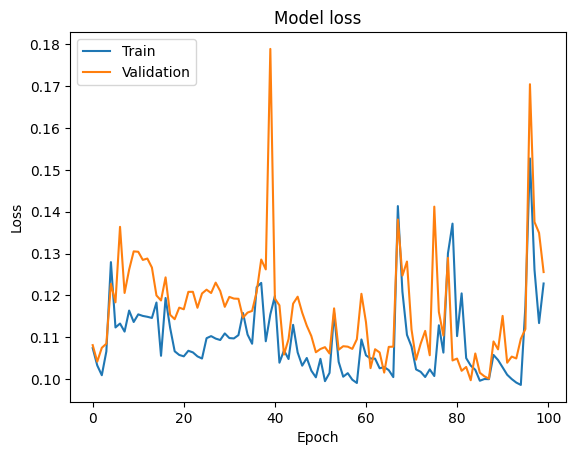

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 700us/step
[[336   1]
 [ 11 302]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       337
           1       1.00      0.96      0.98       313

    accuracy                           0.98       650
   macro avg       0.98      0.98      0.98       650
weighted avg       0.98      0.98      0.98       650



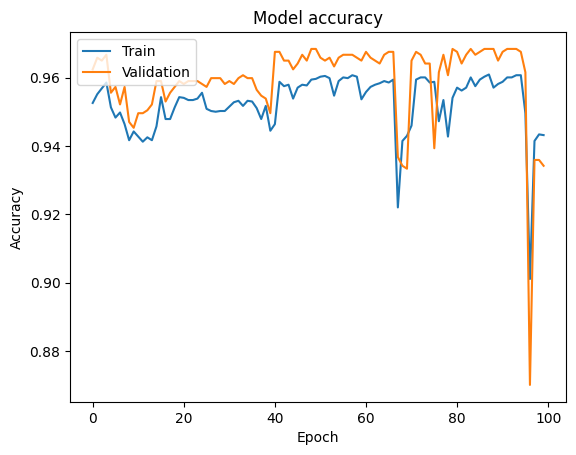

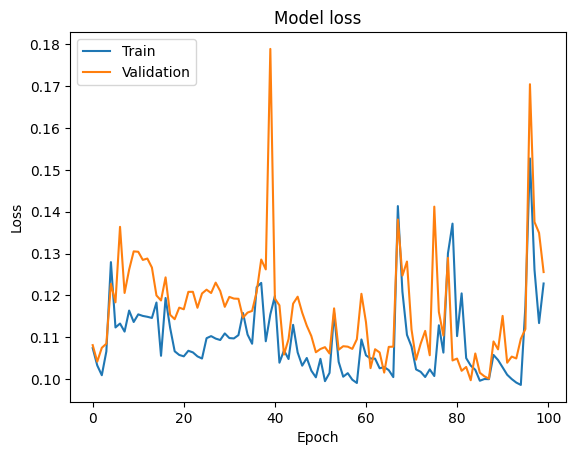

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 800us/step
[[331   6]
 [  5 308]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       337
           1       0.98      0.98      0.98       313

    accuracy                           0.98       650
   macro avg       0.98      0.98      0.98       650
weighted avg       0.98      0.98      0.98       650



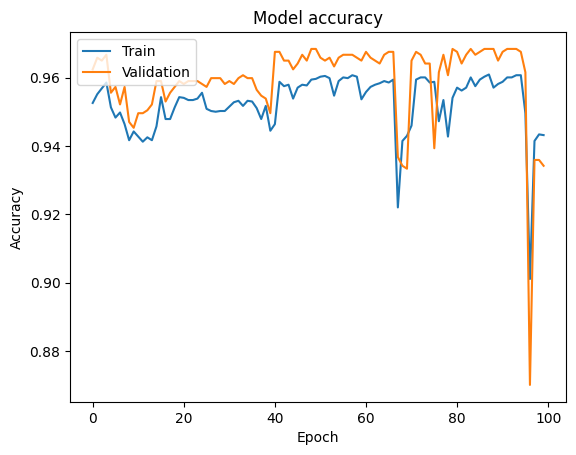

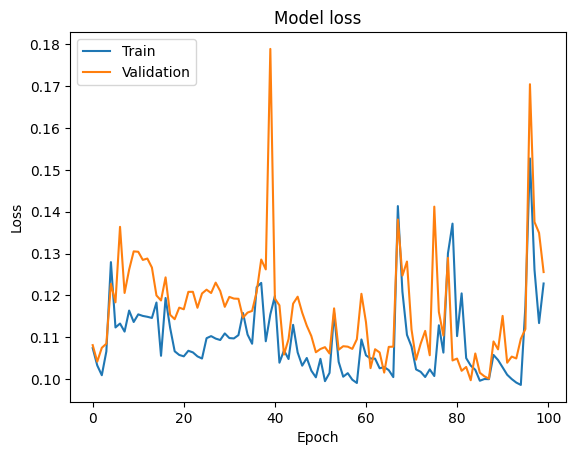

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 700us/step
[[333   4]
 [  9 304]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       337
           1       0.99      0.97      0.98       313

    accuracy                           0.98       650
   macro avg       0.98      0.98      0.98       650
weighted avg       0.98      0.98      0.98       650



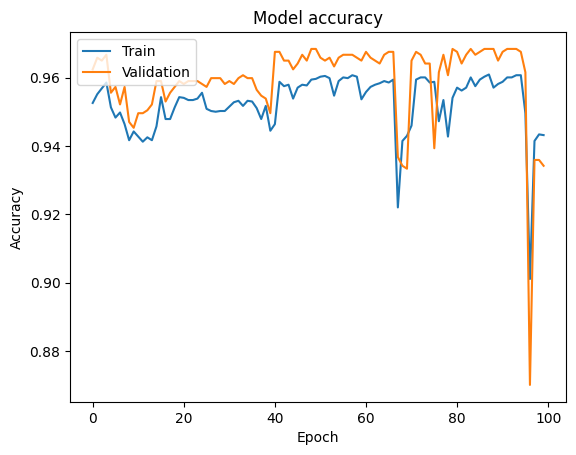

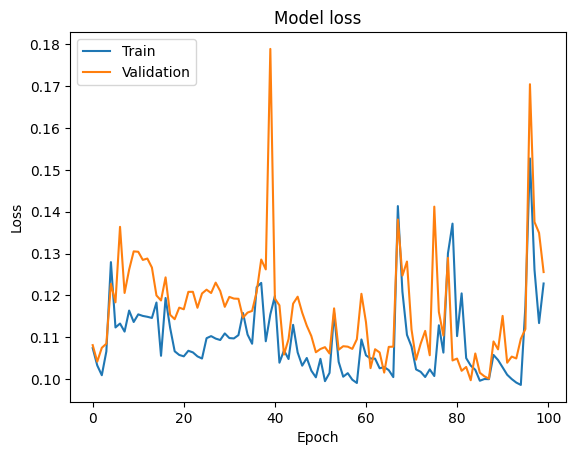

[   0    1    2 ... 5847 5848 5849]
21/21 [==============================] - 0s 650us/step
[[334   2]
 [ 15 298]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       336
           1       0.99      0.95      0.97       313

    accuracy                           0.97       649
   macro avg       0.98      0.97      0.97       649
weighted avg       0.97      0.97      0.97       649



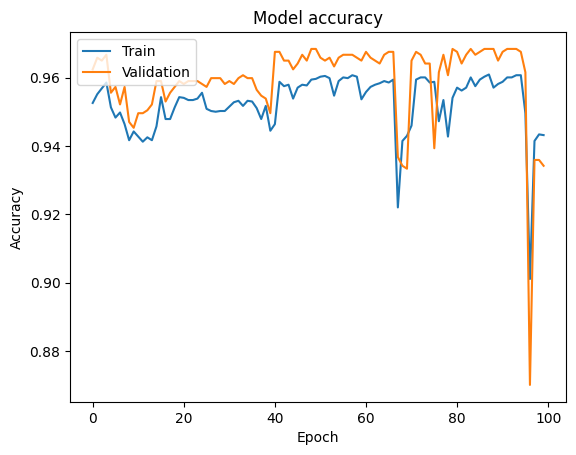

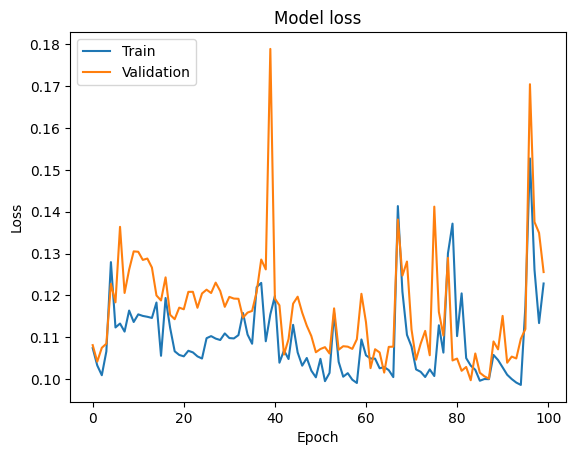

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_4 (Dense)             (None, 128)               896       
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


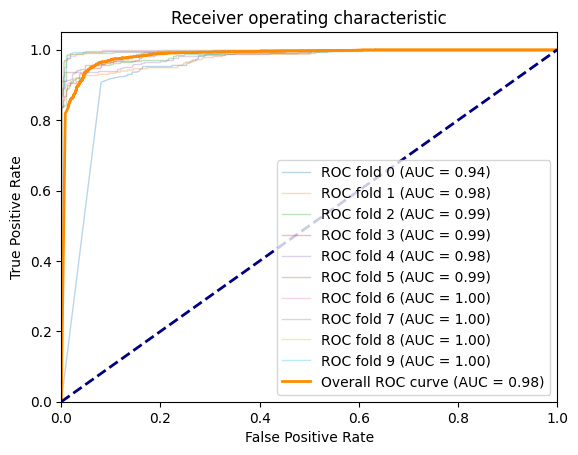

In [20]:
from keras.layers import concatenate
from sklearn.metrics import roc_curve, auc

# Train a model only using crossed values
# get crossed columns

accuracies = []

def create_model(optimizer='adam', activation='relu', hidden_layers_before=2, neurons=128):
    num_features = linear_pca_results_train.shape[1]
    input_tensor = Input(shape=(num_features,))

    x = Dense(units=neurons, activation=activation)(input_tensor)
                         
    wide_branch = Dense(units=1, activation='sigmoid', name='wide')(input_tensor)  # Use input_tensor directly
                         
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_tensor, outputs=predictions)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model_1 = create_model()
idx = 0

# Initialize lists to store the true and predicted labels and the ROC curve data
y_true_list = []
y_proba_list = []
fpr_list = []
tpr_list = []
auc_list = []

for train, test in data_splits.split(train_samples, train_target):
    print(train)
    X_training_fold = linear_pca_results_train[train]
    y_training_fold = train_target.iloc[train]
    
    X_test = linear_pca_results_train[test]
    y_test = train_target.iloc[test]

    model_1.fit(X_training_fold,
            y_training_fold, epochs=100, batch_size=32, verbose=0)

    yhat_proba = model_1.predict(X_test)
    yhat = np.round(yhat_proba)

    # Compute the ROC curve and AUC for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, yhat_proba)
    roc_auc = auc(fpr, tpr)

    # Append the true labels, predicted probabilities, and ROC curve data to the lists
    y_true_list.append(y_test)
    y_proba_list.append(yhat_proba)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

    print(mt.confusion_matrix(y_test,yhat))
    print(mt.classification_report(y_test,yhat))
    accuracies.append({"Confusion Matrix": mt.confusion_matrix(y_test,yhat), "Classification Report": mt.classification_report(y_test,yhat)})
    idx += 1
    plot_model_history(history)

model_1.summary()

# Compute the overall ROC curve and AUC for all the folds
y_true = np.concatenate(y_true_list)
y_proba = np.concatenate(y_proba_list)
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve for each fold and the overall ROC curve
plt.figure()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, auc_list[i]))
plt.plot(fpr, tpr, lw=2, color='darkorange', label='Overall ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

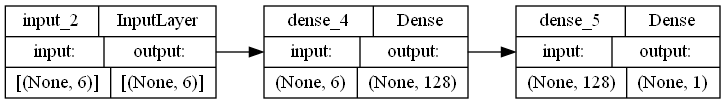

In [21]:
plot_model(
    model_1, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Now lets try something different, let's try to create multiple dense layers, and a wide layer then another dense layer and see what happens. The purpose of this is to demonstrate how multiple dense layers may be necessary before refeeding the initial input tensor again into a wide layer.

[ 648  649  651 ... 6496 6497 6498]
21/21 [==============================] - 0s 650us/step
[[258  78]
 [ 84 230]]
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       336
           1       0.75      0.73      0.74       314

    accuracy                           0.75       650
   macro avg       0.75      0.75      0.75       650
weighted avg       0.75      0.75      0.75       650



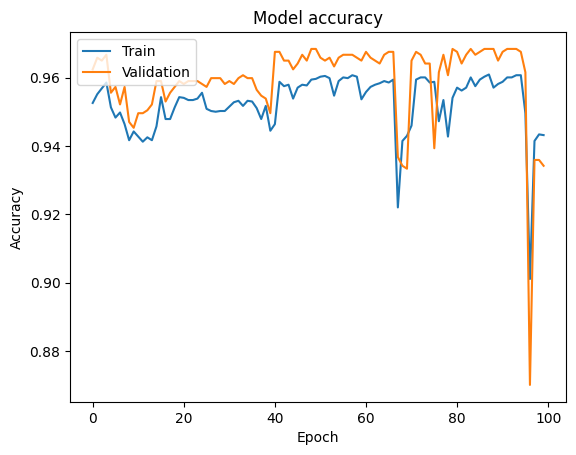

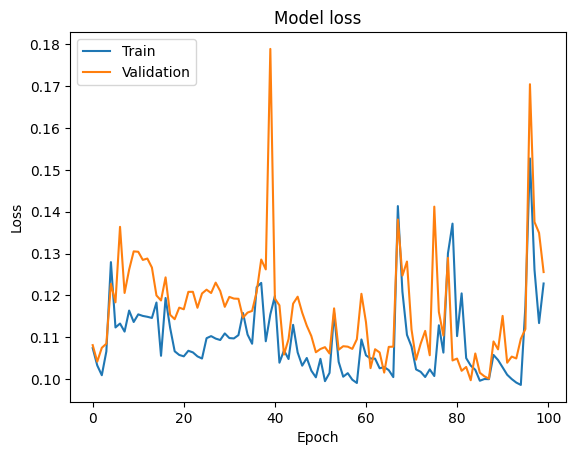

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 674us/step
[[255  81]
 [ 86 228]]
              precision    recall  f1-score   support

           0       0.75      0.76      0.75       336
           1       0.74      0.73      0.73       314

    accuracy                           0.74       650
   macro avg       0.74      0.74      0.74       650
weighted avg       0.74      0.74      0.74       650



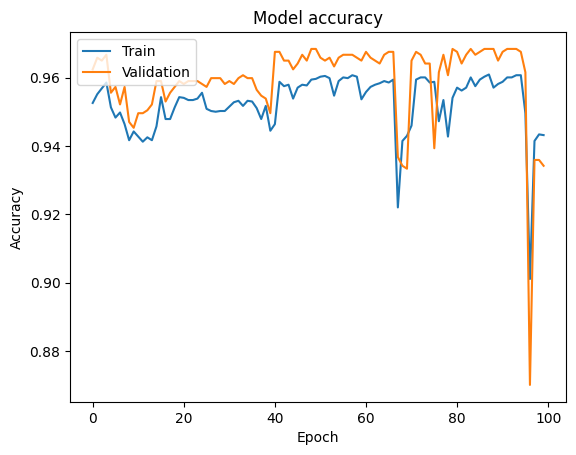

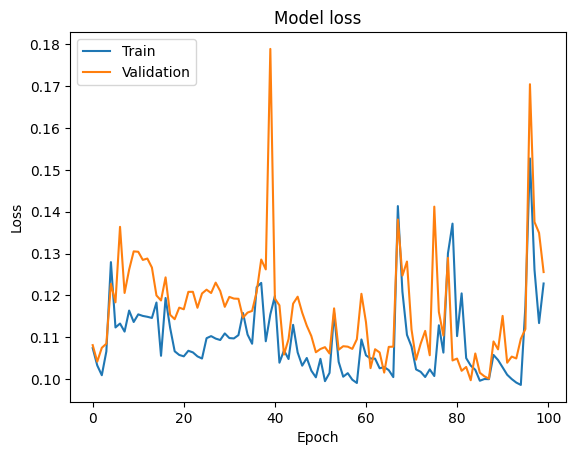

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 700us/step
[[264  72]
 [102 212]]
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       336
           1       0.75      0.68      0.71       314

    accuracy                           0.73       650
   macro avg       0.73      0.73      0.73       650
weighted avg       0.73      0.73      0.73       650



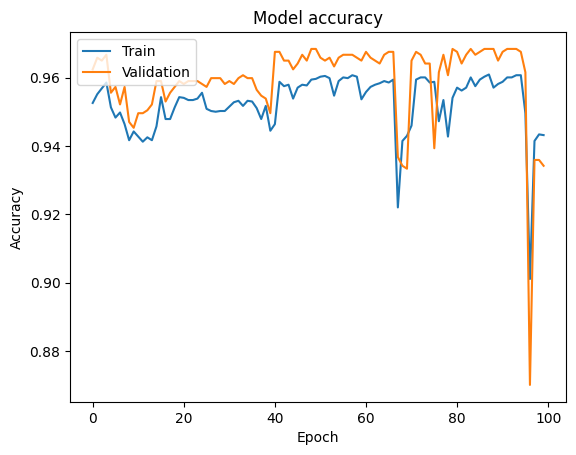

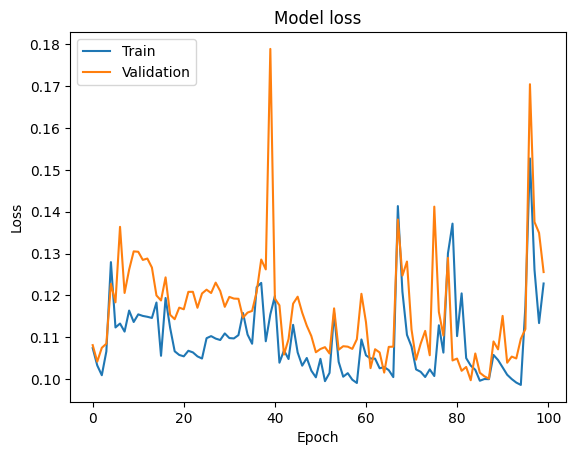

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 700us/step
[[262  75]
 [ 99 214]]
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       337
           1       0.74      0.68      0.71       313

    accuracy                           0.73       650
   macro avg       0.73      0.73      0.73       650
weighted avg       0.73      0.73      0.73       650



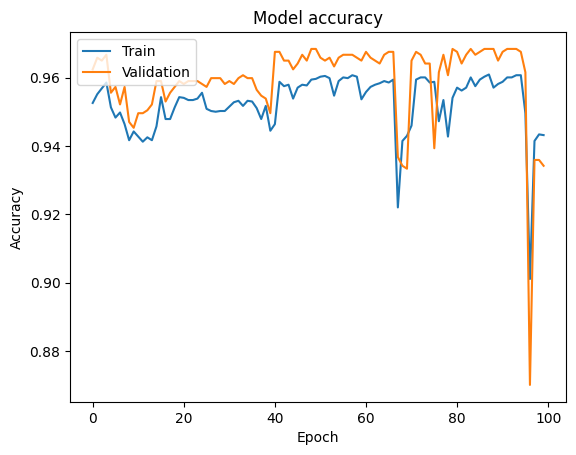

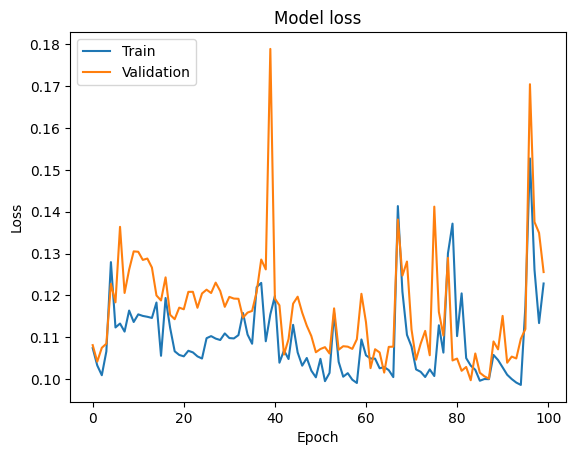

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 676us/step
[[269  68]
 [100 213]]
              precision    recall  f1-score   support

           0       0.73      0.80      0.76       337
           1       0.76      0.68      0.72       313

    accuracy                           0.74       650
   macro avg       0.74      0.74      0.74       650
weighted avg       0.74      0.74      0.74       650



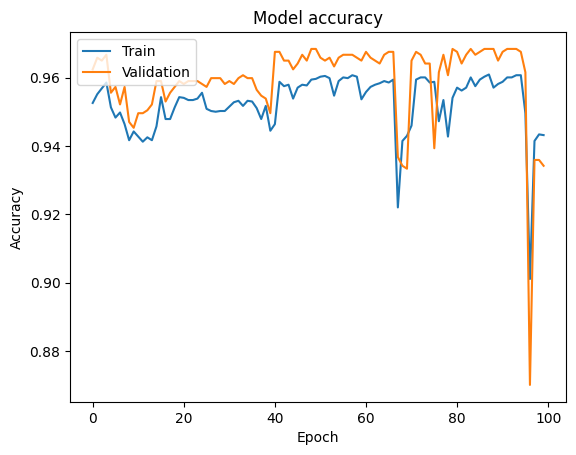

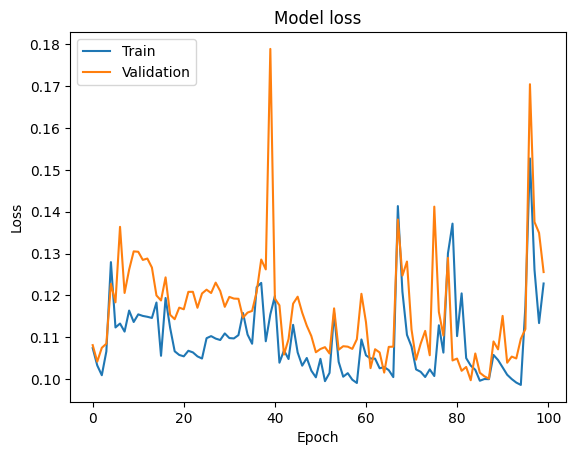

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 725us/step
[[270  67]
 [102 211]]
              precision    recall  f1-score   support

           0       0.73      0.80      0.76       337
           1       0.76      0.67      0.71       313

    accuracy                           0.74       650
   macro avg       0.74      0.74      0.74       650
weighted avg       0.74      0.74      0.74       650



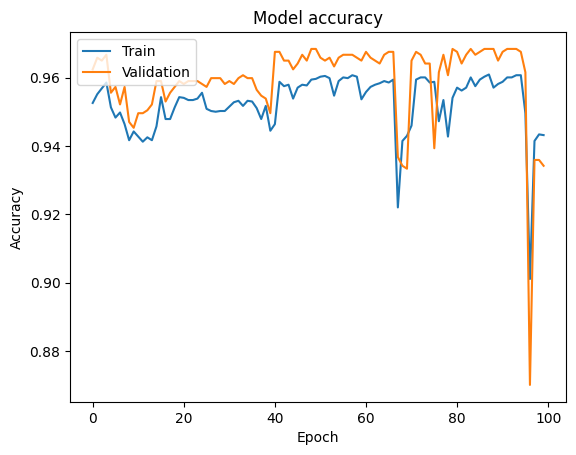

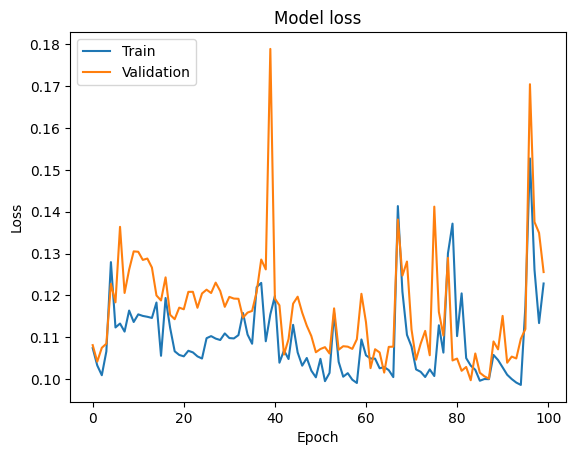

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 775us/step
[[268  69]
 [ 86 227]]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       337
           1       0.77      0.73      0.75       313

    accuracy                           0.76       650
   macro avg       0.76      0.76      0.76       650
weighted avg       0.76      0.76      0.76       650



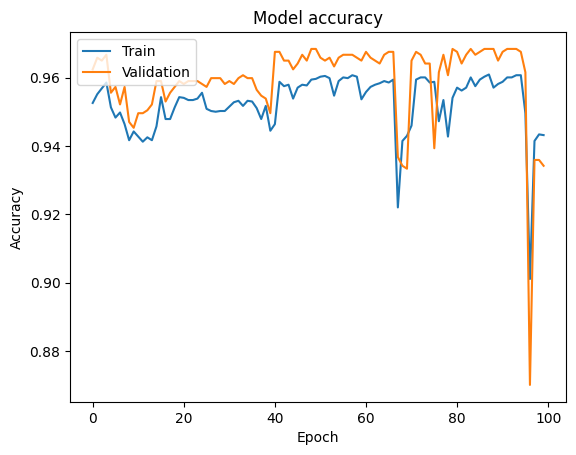

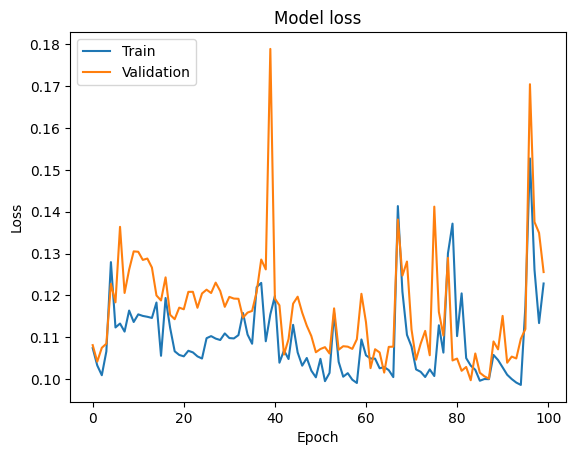

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 650us/step
[[268  69]
 [ 95 218]]
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       337
           1       0.76      0.70      0.73       313

    accuracy                           0.75       650
   macro avg       0.75      0.75      0.75       650
weighted avg       0.75      0.75      0.75       650



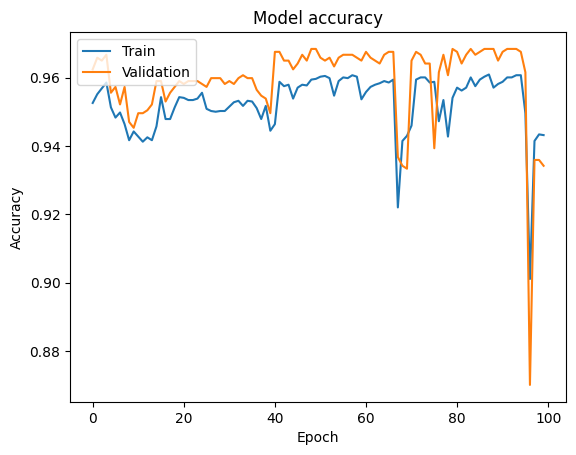

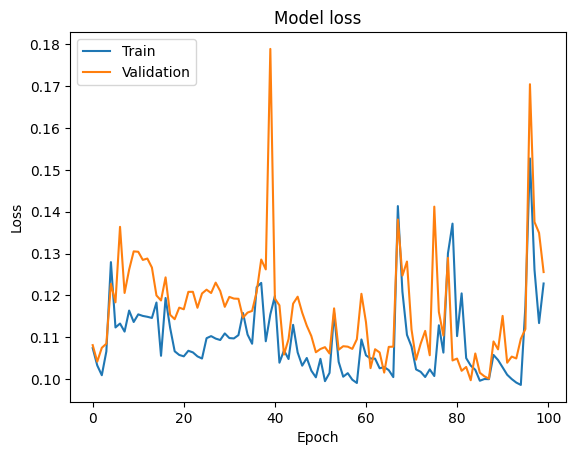

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 700us/step
[[263  74]
 [ 99 214]]
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       337
           1       0.74      0.68      0.71       313

    accuracy                           0.73       650
   macro avg       0.73      0.73      0.73       650
weighted avg       0.73      0.73      0.73       650



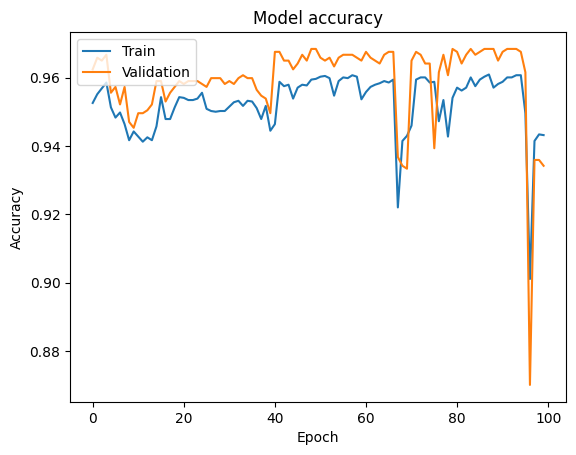

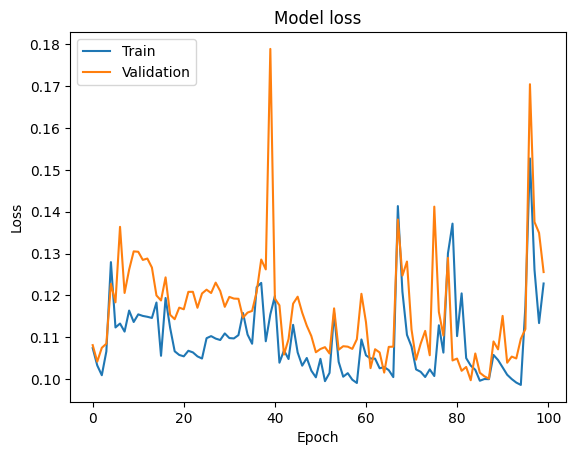

[   0    1    2 ... 5847 5848 5849]
21/21 [==============================] - 0s 651us/step
[[271  65]
 [ 93 220]]
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       336
           1       0.77      0.70      0.74       313

    accuracy                           0.76       649
   macro avg       0.76      0.75      0.76       649
weighted avg       0.76      0.76      0.76       649



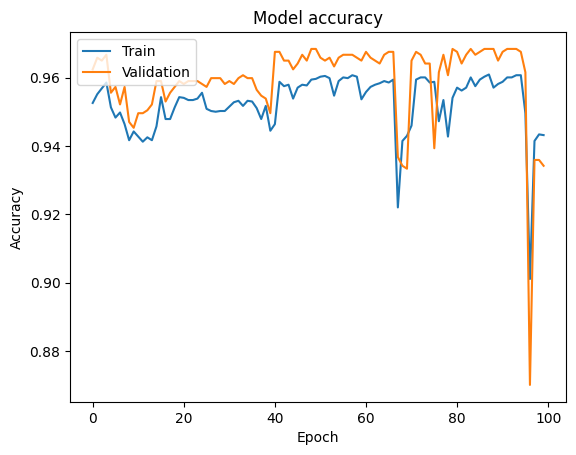

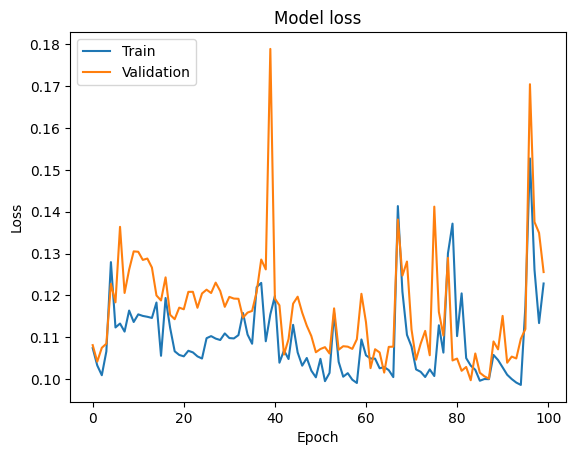

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6)]               0         
                                                                 
 wide (Dense)                (None, 1)                 7         
                                                                 
 dense_7 (Dense)             (None, 128)               256       
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 392
Trainable params: 392
Non-trainable params: 0
_________________________________________________________________


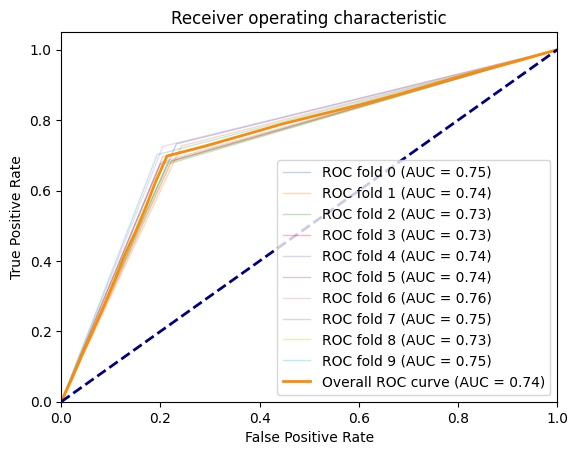

In [22]:
from keras.layers import concatenate

accuracies = []

def create_model(optimizer='adam', activation='relu', hidden_layers_before=2, neurons=128):
    num_features = linear_pca_results_train.shape[1]
    input_tensor = Input(shape=(num_features,))

    x = Dense(units=neurons, activation=activation)(input_tensor)
                         
    wide_branch = Dense(units=1, activation='sigmoid', name='wide')(input_tensor) # Use input_tensor directly
    
    x = Dense(units=neurons, activation=activation)(wide_branch)

    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_tensor, outputs=predictions)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model_2 = create_model()
idx = 0

from sklearn.metrics import roc_curve, auc

# Initialize lists to store the true and predicted labels and the ROC curve data
y_true_list = []
y_proba_list = []
fpr_list = []
tpr_list = []
auc_list = []

for train, test in data_splits.split(train_samples, train_target):
    print(train)
    X_training_fold = linear_pca_results_train[train]
    y_training_fold = train_target.iloc[train]
    
    X_test = linear_pca_results_train[test]
    y_test = train_target.iloc[test]

    model_2.fit(X_training_fold,
            y_training_fold, epochs=100, batch_size=32, verbose=0)

    yhat_proba = model_2.predict(X_test)
    yhat = np.round(yhat_proba)

    # Compute the ROC curve and AUC for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, yhat_proba)
    roc_auc = auc(fpr, tpr)

    # Append the true labels, predicted probabilities, and ROC curve data to the lists
    y_true_list.append(y_test)
    y_proba_list.append(yhat_proba)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

    print(mt.confusion_matrix(y_test,yhat))
    print(mt.classification_report(y_test,yhat))
    accuracies.append({"Confusion Matrix": mt.confusion_matrix(y_test,yhat), "Classification Report": mt.classification_report(y_test,yhat)})
    plot_model_history(history)
    idx += 1

model_2.summary()

# Compute the overall ROC curve and AUC for all the folds
y_true = np.concatenate(y_true_list)
y_proba = np.concatenate(y_proba_list)
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve for each fold and the overall ROC curve
plt.figure()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, auc_list[i]))
plt.plot(fpr, tpr, lw=2, color='darkorange', label='Overall ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

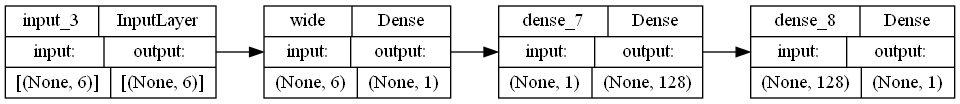

In [23]:
plot_model(
    model_2, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Ok, now lastly let's create an several Deep layers, then add a wide with consecutive Deep layers, and a second wide layer with another Deep layer before calculating the output.

[ 648  649  651 ... 6496 6497 6498]
21/21 [==============================] - 0s 750us/step
[[182 154]
 [152 162]]
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       336
           1       0.51      0.52      0.51       314

    accuracy                           0.53       650
   macro avg       0.53      0.53      0.53       650
weighted avg       0.53      0.53      0.53       650



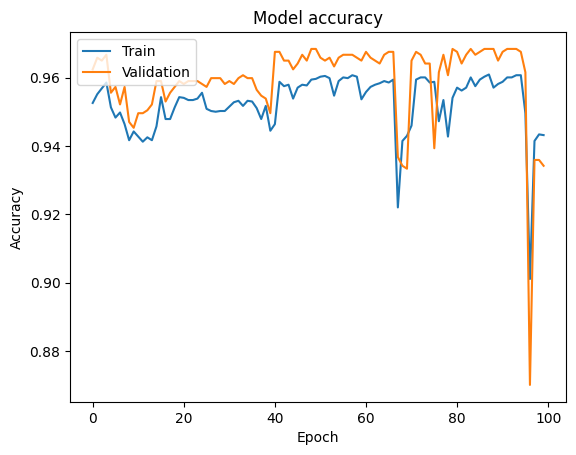

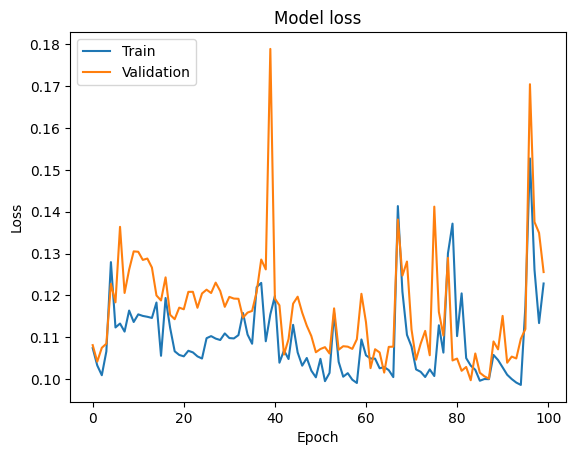

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 750us/step
[[199 137]
 [142 172]]
              precision    recall  f1-score   support

           0       0.58      0.59      0.59       336
           1       0.56      0.55      0.55       314

    accuracy                           0.57       650
   macro avg       0.57      0.57      0.57       650
weighted avg       0.57      0.57      0.57       650



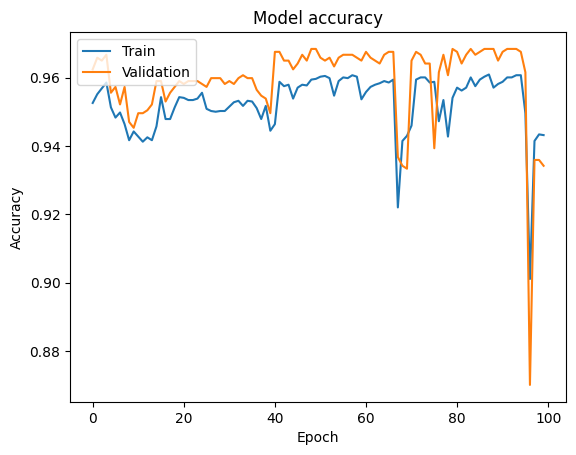

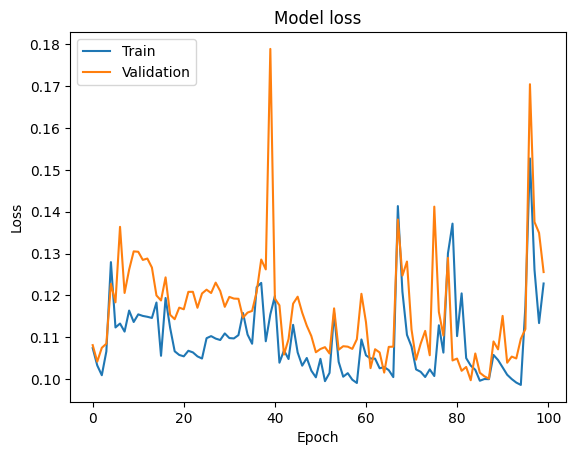

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 700us/step
[[181 155]
 [141 173]]
              precision    recall  f1-score   support

           0       0.56      0.54      0.55       336
           1       0.53      0.55      0.54       314

    accuracy                           0.54       650
   macro avg       0.54      0.54      0.54       650
weighted avg       0.55      0.54      0.54       650



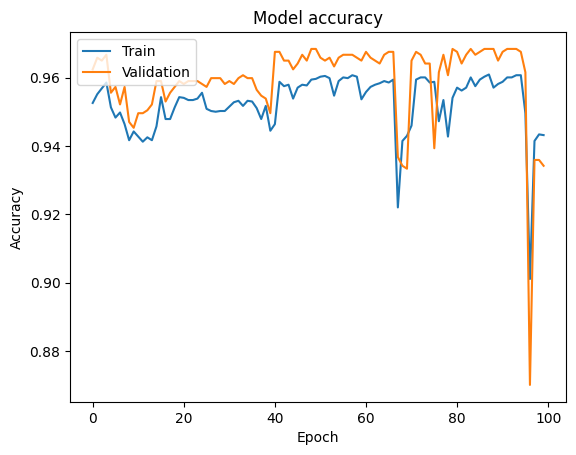

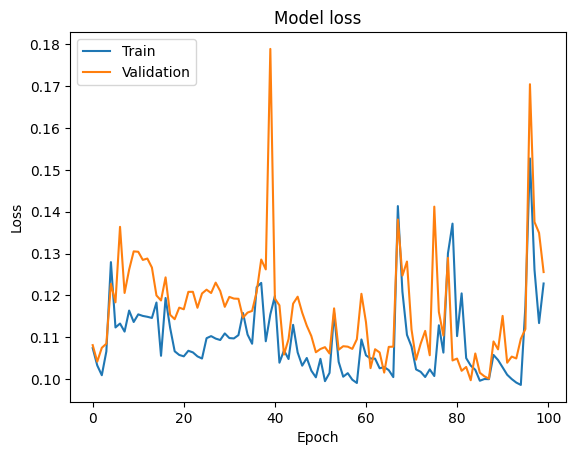

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 750us/step
[[192 145]
 [137 176]]
              precision    recall  f1-score   support

           0       0.58      0.57      0.58       337
           1       0.55      0.56      0.56       313

    accuracy                           0.57       650
   macro avg       0.57      0.57      0.57       650
weighted avg       0.57      0.57      0.57       650



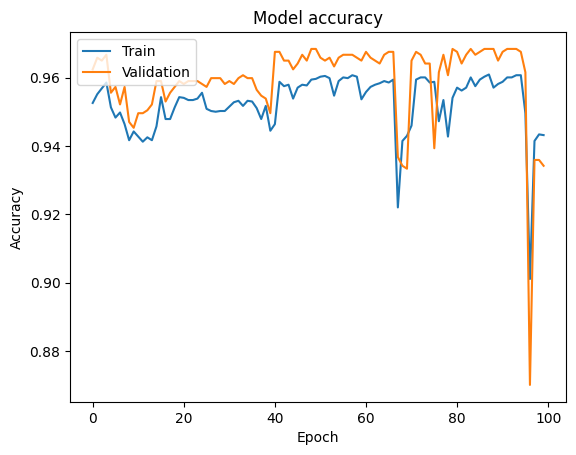

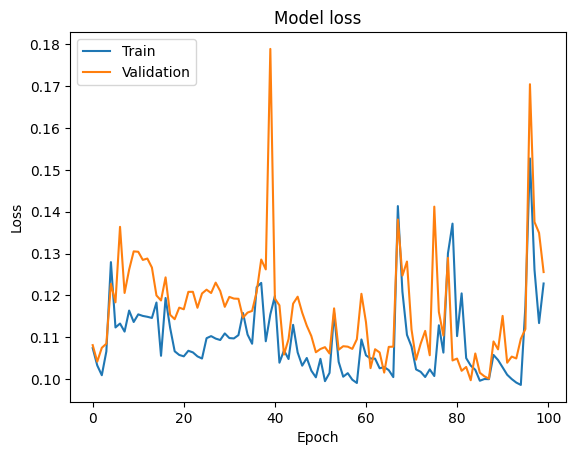

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 675us/step
[[203 134]
 [135 178]]
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       337
           1       0.57      0.57      0.57       313

    accuracy                           0.59       650
   macro avg       0.59      0.59      0.59       650
weighted avg       0.59      0.59      0.59       650



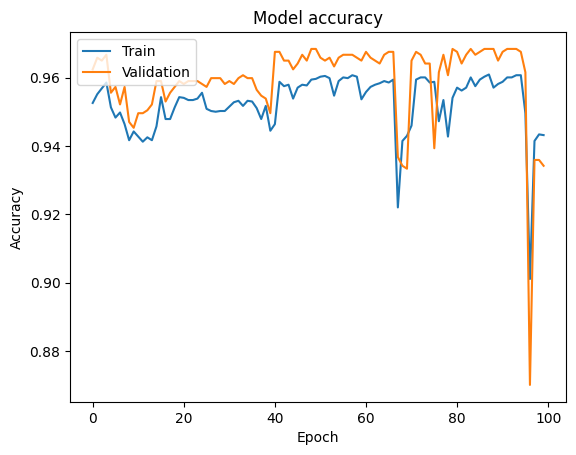

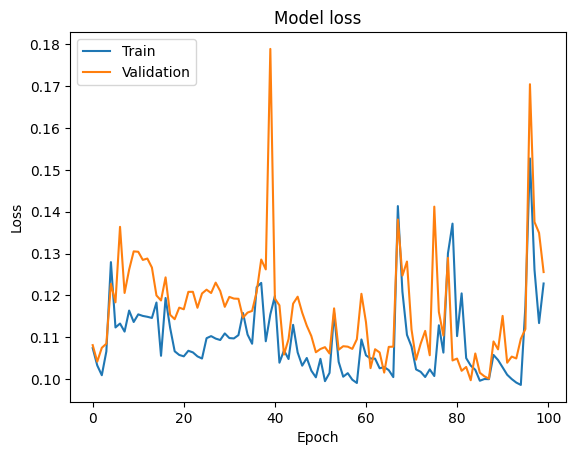

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 675us/step
[[188 149]
 [135 178]]
              precision    recall  f1-score   support

           0       0.58      0.56      0.57       337
           1       0.54      0.57      0.56       313

    accuracy                           0.56       650
   macro avg       0.56      0.56      0.56       650
weighted avg       0.56      0.56      0.56       650



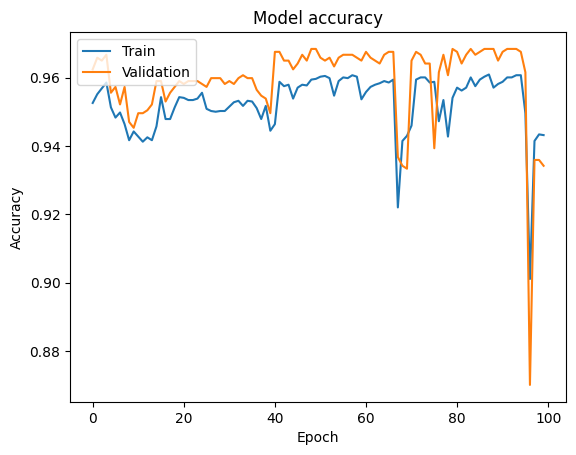

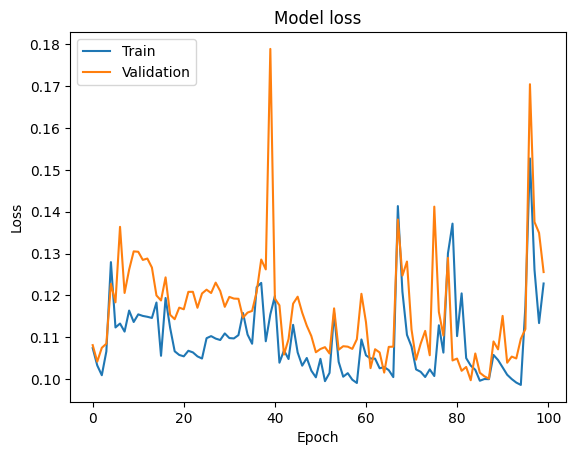

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 675us/step
[[195 142]
 [124 189]]
              precision    recall  f1-score   support

           0       0.61      0.58      0.59       337
           1       0.57      0.60      0.59       313

    accuracy                           0.59       650
   macro avg       0.59      0.59      0.59       650
weighted avg       0.59      0.59      0.59       650



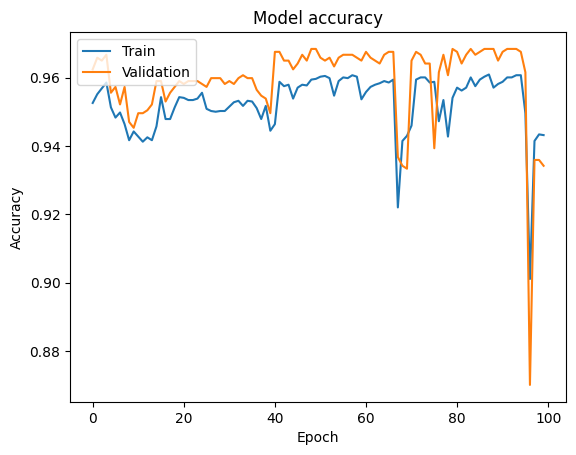

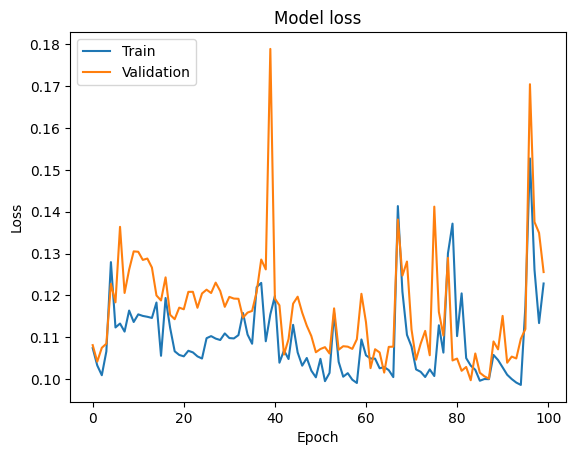

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 750us/step
[[186 151]
 [131 182]]
              precision    recall  f1-score   support

           0       0.59      0.55      0.57       337
           1       0.55      0.58      0.56       313

    accuracy                           0.57       650
   macro avg       0.57      0.57      0.57       650
weighted avg       0.57      0.57      0.57       650



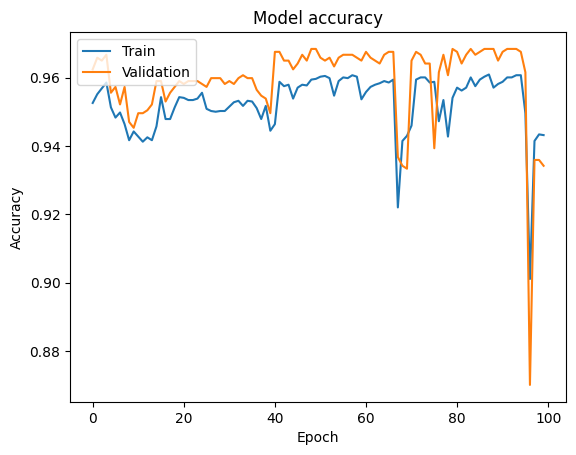

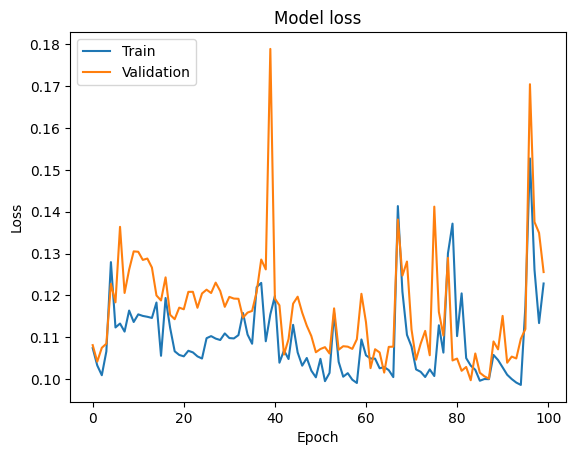

[   0    1    2 ... 6496 6497 6498]
21/21 [==============================] - 0s 900us/step
[[177 160]
 [142 171]]
              precision    recall  f1-score   support

           0       0.55      0.53      0.54       337
           1       0.52      0.55      0.53       313

    accuracy                           0.54       650
   macro avg       0.54      0.54      0.54       650
weighted avg       0.54      0.54      0.54       650



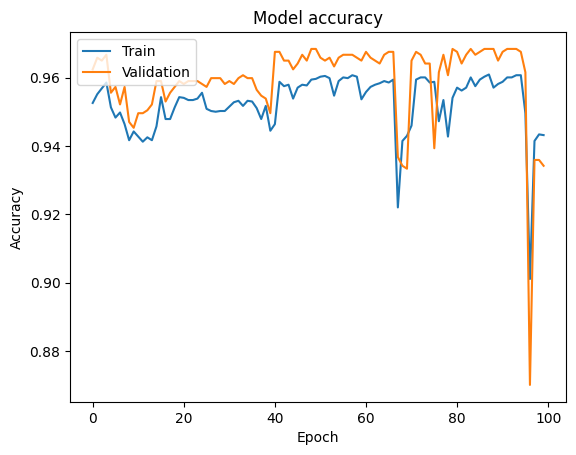

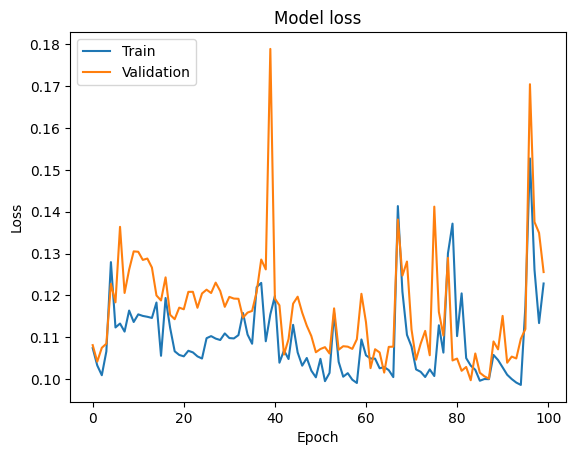

[   0    1    2 ... 5847 5848 5849]
21/21 [==============================] - 0s 726us/step
[[192 144]
 [138 175]]
              precision    recall  f1-score   support

           0       0.58      0.57      0.58       336
           1       0.55      0.56      0.55       313

    accuracy                           0.57       649
   macro avg       0.57      0.57      0.57       649
weighted avg       0.57      0.57      0.57       649



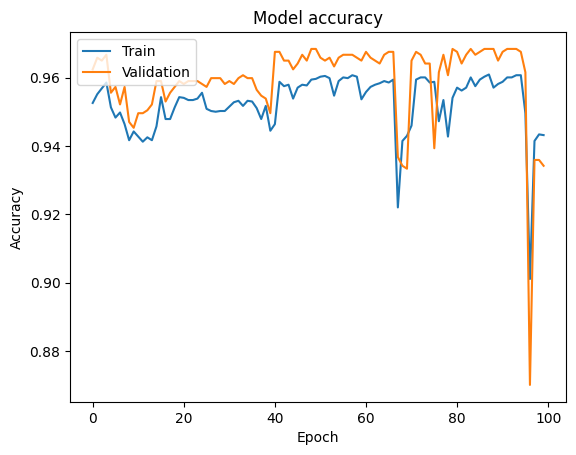

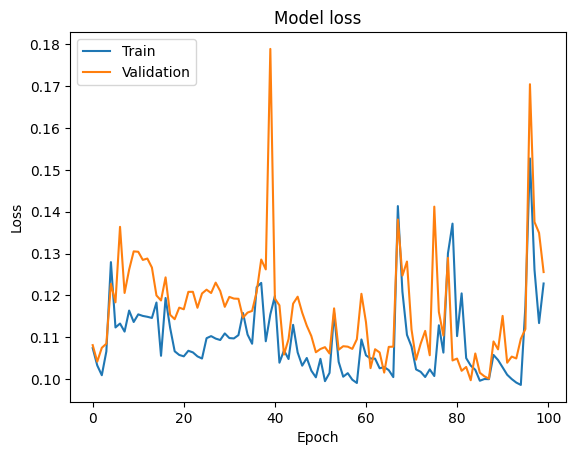

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 6)]               0         
                                                                 
 wide (Dense)                (None, 1)                 7         
                                                                 
 dense_13 (Dense)            (None, 128)               256       
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 16,904
Trainable params: 16,904
Non-trainable params: 0
_________________________________________________________________


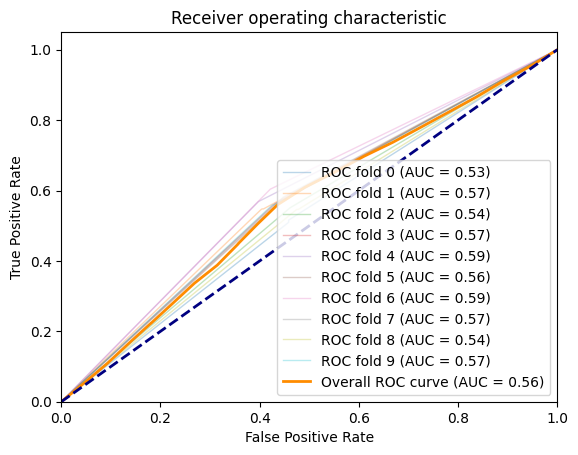

In [24]:
from keras.layers import concatenate

accuracies = []

def create_model(optimizer='adam', activation='relu', hidden_layers_before=2, neurons=128):
    num_features = linear_pca_results_train.shape[1]
    input_tensor = Input(shape=(num_features,))

    x = Dense(units=neurons, activation=activation)(input_tensor)
    x = Dense(units=neurons, activation=activation)(x)
                         
    wide_branch = Dense(units=1, activation='sigmoid', name='wide')(input_tensor) 
    
    x = Dense(units=neurons, activation=activation)(wide_branch)
    x = Dense(units=neurons, activation=activation)(x)
    wide_branch = Dense(units=1, activation='sigmoid', name='wide')(input_tensor)
    
    x = Dense(units=neurons, activation=activation)(wide_branch)
    x = Dense(units=neurons, activation=activation)(x)
    

    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_tensor, outputs=predictions)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model_3 = create_model()
idx = 0

from sklearn.metrics import roc_curve, auc

# Initialize lists to store the true and predicted labels and the ROC curve data
y_true_list = []
y_proba_list = []
fpr_list = []
tpr_list = []
auc_list = []

for train, test in data_splits.split(train_samples, train_target):
    print(train)
    X_training_fold = linear_pca_results_train[train]
    y_training_fold = train_target.iloc[train]
    
    X_test = linear_pca_results_train[test]
    y_test = train_target.iloc[test]

    model_3.fit(X_training_fold,
            y_training_fold, epochs=100, batch_size=32, verbose=0)

    yhat_proba = model_3.predict(X_test)
    yhat = np.round(yhat_proba)

    # Compute the ROC curve and AUC for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, yhat_proba)
    roc_auc = auc(fpr, tpr)

    # Append the true labels, predicted probabilities, and ROC curve data to the lists
    y_true_list.append(y_test)
    y_proba_list.append(yhat_proba)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

    print(mt.confusion_matrix(y_test,yhat))
    print(mt.classification_report(y_test,yhat))
    accuracies.append({"Confusion Matrix": mt.confusion_matrix(y_test,yhat), "Classification Report": mt.classification_report(y_test,yhat)})
    plot_model_history(history)
    idx += 1

model_3.summary()

# Compute the overall ROC curve and AUC for all the folds
y_true = np.concatenate(y_true_list)
y_proba = np.concatenate(y_proba_list)
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve for each fold and the overall ROC curve
plt.figure()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, auc_list[i]))
plt.plot(fpr, tpr, lw=2, color='darkorange', label='Overall ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

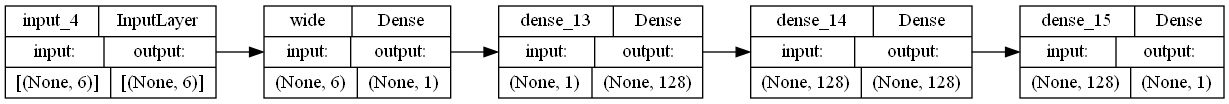

In [25]:
plot_model(
    model_3, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

# PLACEHOLDER BELOW